# 0.0 IMPORTS

In [1]:
import math
import pickle
import random
import warnings
import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb


from scipy                 import stats as ss
from tabulate              import tabulate
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML

from boruta                import BorutaPy
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [2]:
def cramer_v( x, y):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr =max(0, chi2 - ( k-1) * (r-1) / (n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( ( chi2corr/n ) / (min( kcorr-1, rcorr-1 ) ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat)
    mape = mean_absolute_percentage_error( y, yhat)
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse}, index=[0] )

def mean_percentage_error( y, yhat ):
    return np.mean( (y - yhat ) / y ) 

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        
        # model
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('/Users/marcoscarvalho/data-science-em-producao/data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('/Users/marcoscarvalho/data-science-em-producao/data/store.csv', low_memory = False)

# merge 
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 PASSO 01 - DATA DESCRIPTION

**The motivation for describing the data is to find out how challenging the problem we are dealing with is based on understanding the data and the steps to be taken are:**

- Do I have the right resources to develop the project?


- What types of variables are available? 
    - % Numerical
    - % Categoricals
    - % Time variables


- Do we have missing data? What volume? Why is data missing (old legacy syste, manual input)?


- Descriptive statistics: used to gain greater business knowledge through central tendencies and dispersion analysis

In [5]:
df1 = df_raw.copy()

## Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.1 Rename Columns

In [6]:
# rename columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ) )

df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print( 'Number of Rows: {}.'.format( df1.shape[0] ) )
print( 'Number of Cols: {}.'.format( df1.shape[1] ) )

Number of Rows: 1017209.
Number of Cols: 18.


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                                                               else x['competition_open_since_month'], axis=1 )
#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) 
                                                                               else x['competition_open_since_year'], axis=1 )                 
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
                                                                else x['promo2_since_week'], axis=1)
#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
                                                                else x['promo2_since_year'], axis=1)                 
#promo_interval                  
month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
                                                            else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [14]:
# Central Tendence - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median) ).T

# Dispersion - std, var, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.var ) ).T
d3 = pd.DataFrame( num_attributes.apply( min ) ).T
d4 = pd.DataFrame( num_attributes.apply( max ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d7 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d3, d4, d5 , ct1, ct2, d1, d2, d6, d7] ).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','var','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,var,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,1.036251e+05,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,3.989567e+00,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.482192e+07,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,2.156780e+05,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.410296e-01,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,2.359612e-01,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.467320e-01,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,1.574434e+08,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,1.096328e+01,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,3.042174e+01,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

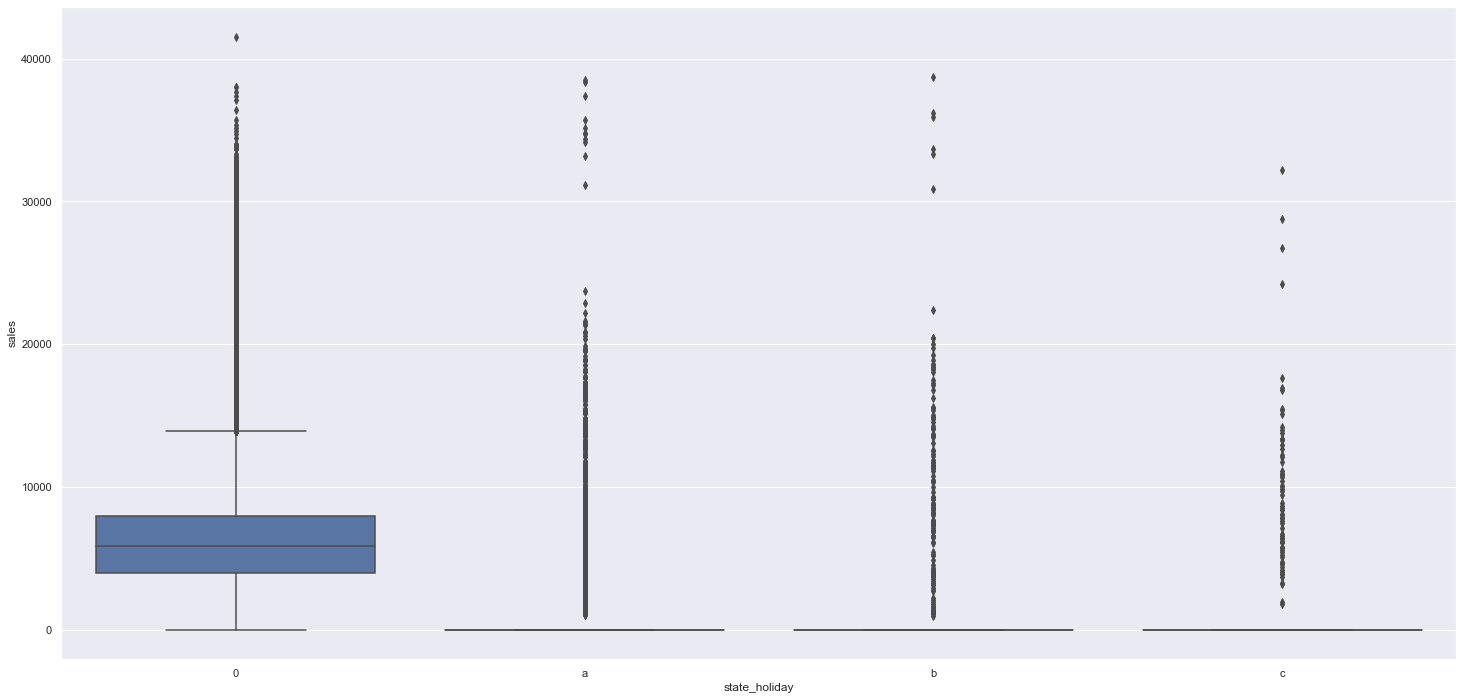

In [16]:
# aqui temos as vendas distribuidas por todas as variaveis a coluna state_holiday, onde 0 representa dias
# sem vendas, o que tem deixado a visualizacao ruim, pois, temos muito mais dias sem feriado do que com
sns.boxplot( x='state_holiday' , y='sales', data=df1 )

<AxesSubplot:xlabel='assortment', ylabel='sales'>

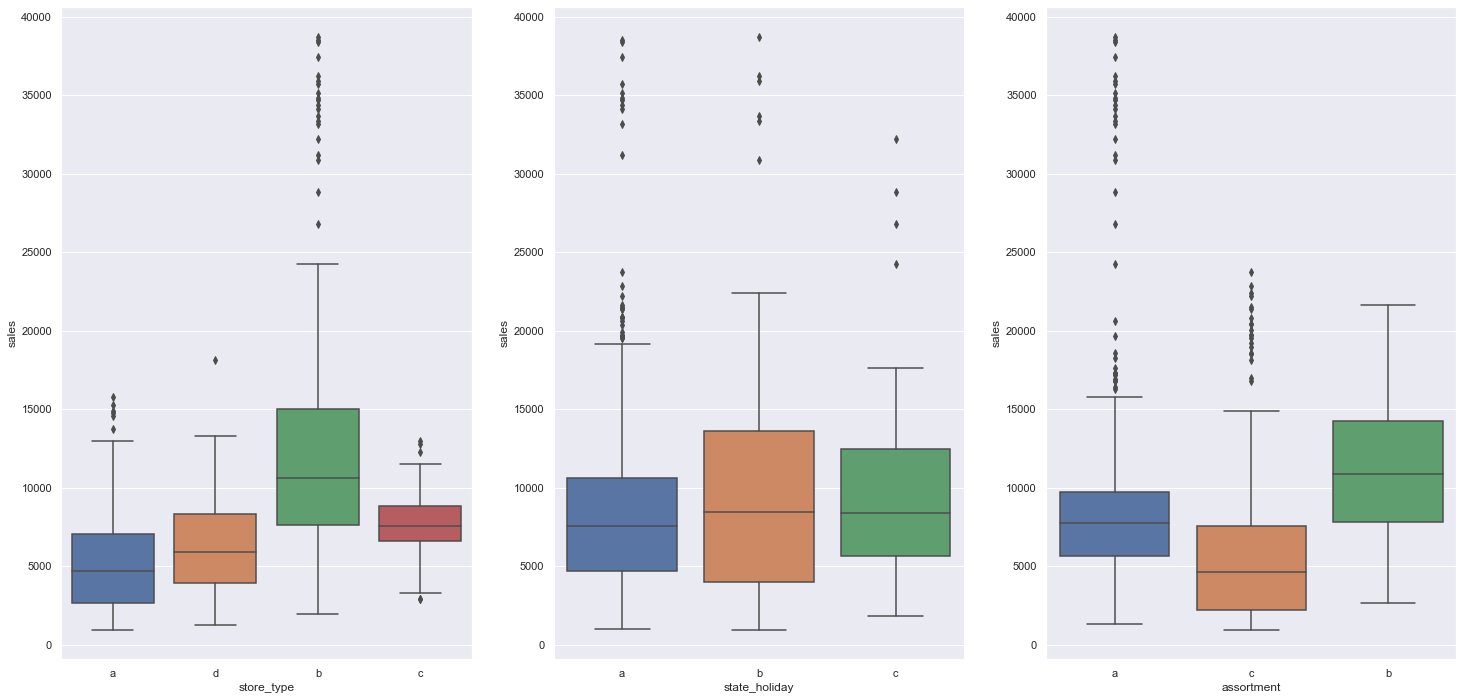

In [17]:
# dado o problema acima, decidi filtrar apenas pelos dias que tiveram feriado e vendas maior do que 0 para analisar
# a distribuicao das vendas em feriados
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='store_type' , y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='state_holiday' , y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment' , y='sales', data=aux1 )

# 2.0. PASSO 02 - FEATURE ENGINEERING

**The motivation of this step is to have the variables available for study during the EDA, not doing feature engineering can and will get in the way at the time of the EDA, because, when plotting the data, we ended up discovering that there are missing columns that should have been derived from the variables in the original dataset**

In [18]:
df2 = df1.copy()

### MindMap Hypothesis

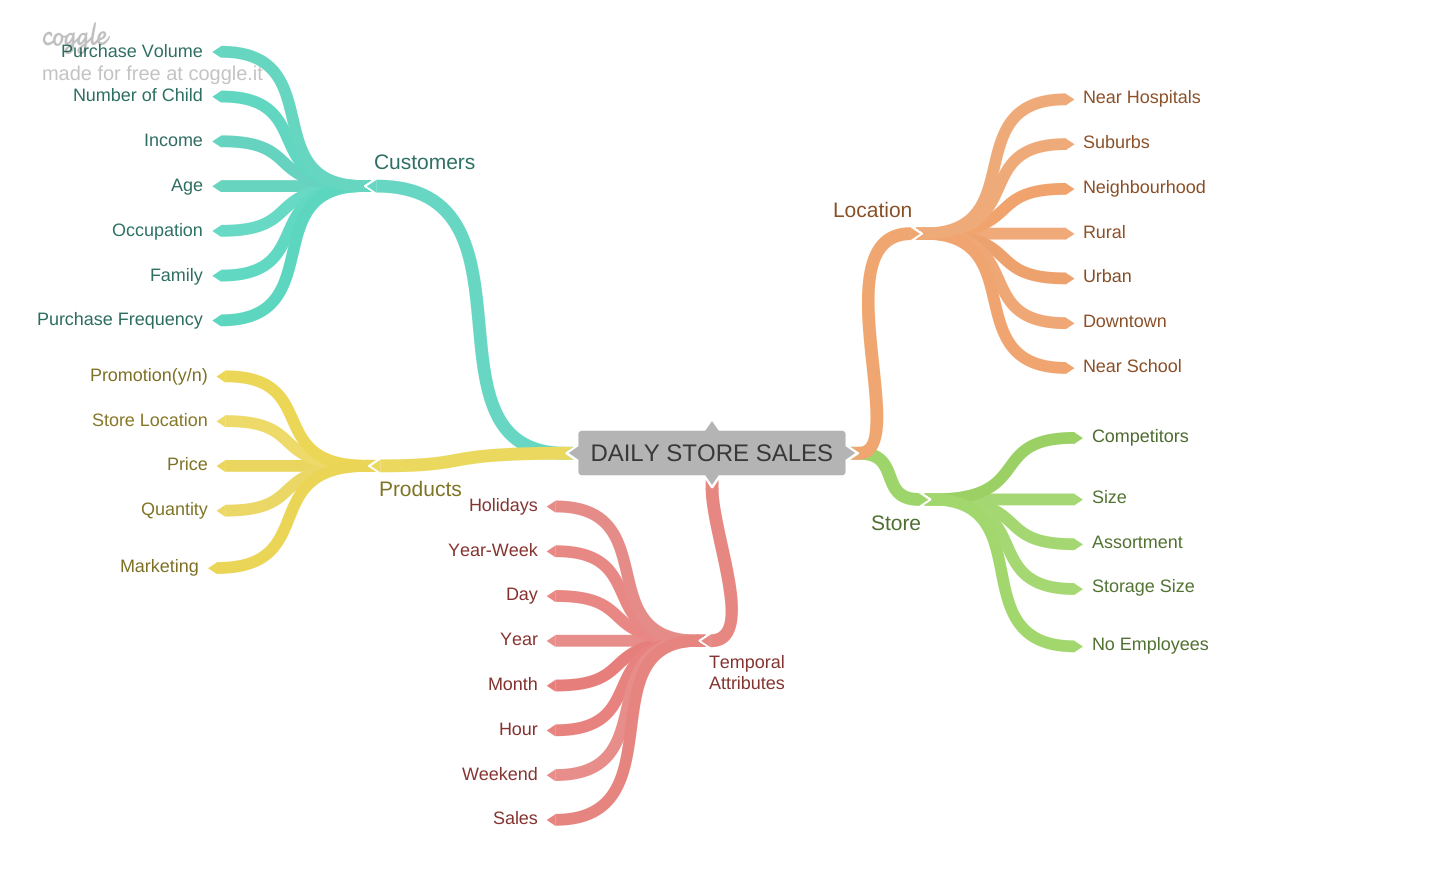

In [19]:
Image('/Users/marcoscarvalho/data-science-em-producao/img/mindmaphypothesis.png')

## 2.1. Creating Hypothesis

### 2.1.1. Store Hypothesis

**1.** Stores with more employees should sell more.

**2.** Stores with greater inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with larger assortments should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

### 2.1.2. Products Hypothesis

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with more product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**4.** Stores with more aggressive promotions (bigger discounts) should sell more.

**5.** Stores with longer active promotions should sell more.

**6.** Stores with more days of promotion should sell more.

**7.** Stores with more consecutive promotions should sell more.

### 2.1.3. Temporal Hypothesis (Seasonality)

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.2 Final Hypothesis List (Prioritized)

**1.** Stores with larger assortments should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with longer active promotions should sell more.

**5.** Stores with more consecutive promotions should sell more.

**6.** Stores open during the Christmas holiday should sell more.

**7.** Stores should sell more over the years.

**8.** Stores should sell more in the second half of the year.

**9.** Stores should sell more after the 10th of each month.

**10.** Stores should sell less on weekends.

**11.** Stores should sell less during school holidays.

## 2.3 Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year-week'] = df2['date'].dt.strftime( '%Y-%W')

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'] , month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'  else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b'  else 'christmas' if x == 'c' else 'regular_day')


# 3.0. PASSO 03 - VARIABLES SELECTION

**The motivation for this step is to remove rows and columns that may somehow interfere with both the EDA and the performance of the model up front, as for example below, days when the stores were closed**

In [21]:
df3 = df2.copy()

## 3.1. Rows Selection

In [22]:
df3 = df3[( df3['open'] != 0 ) &  ( df3['sales'] > 0 )]

## 3.2. Columns Selection

In [23]:
cols_drop = ['customers', 'open', 'promo_interval','month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [24]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year-week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0. PASSO 04 - EXPLORATORY DATA ANALYSIS (EDA)

The motivation for this step is to understand how the variables impact the phenomenon, the strength of this impact and also validate hypothesis to generate insights. EDA serves to measure the impact of variables in relation to the response variable, often trying to quantify this impact. As well as descriptive statistics, it is important to do EDA to gain knowledge of the business and how data is distributed. I will divide the analysis into 3 sections: Univariate, Bivariate and Multivariate.

In [25]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In this analysis, we look at each variable individually, whether numerical or categorical, to understand how the distribution of this variable is and to know better the data we have at hand in order to find any trends.

### 4.1.1. Response Variable

**Assumptions:**

- Kurtosis of this distribution is good, with the tails well divided, representing an almost normal distribution;


- Skew more to the left which represents a positive skew but not centered, which is not a problem, because as mentioned above, it is very close to a normal distribution; 


- We care about the distribution because machine learning algorithms, at least most are created based on some assumptions and behaviors of the environment, in this case the data distribution space. One of the conditions is that the data are independent and normally distributed, because the more normal the response variable, the better the algorithm will perform.

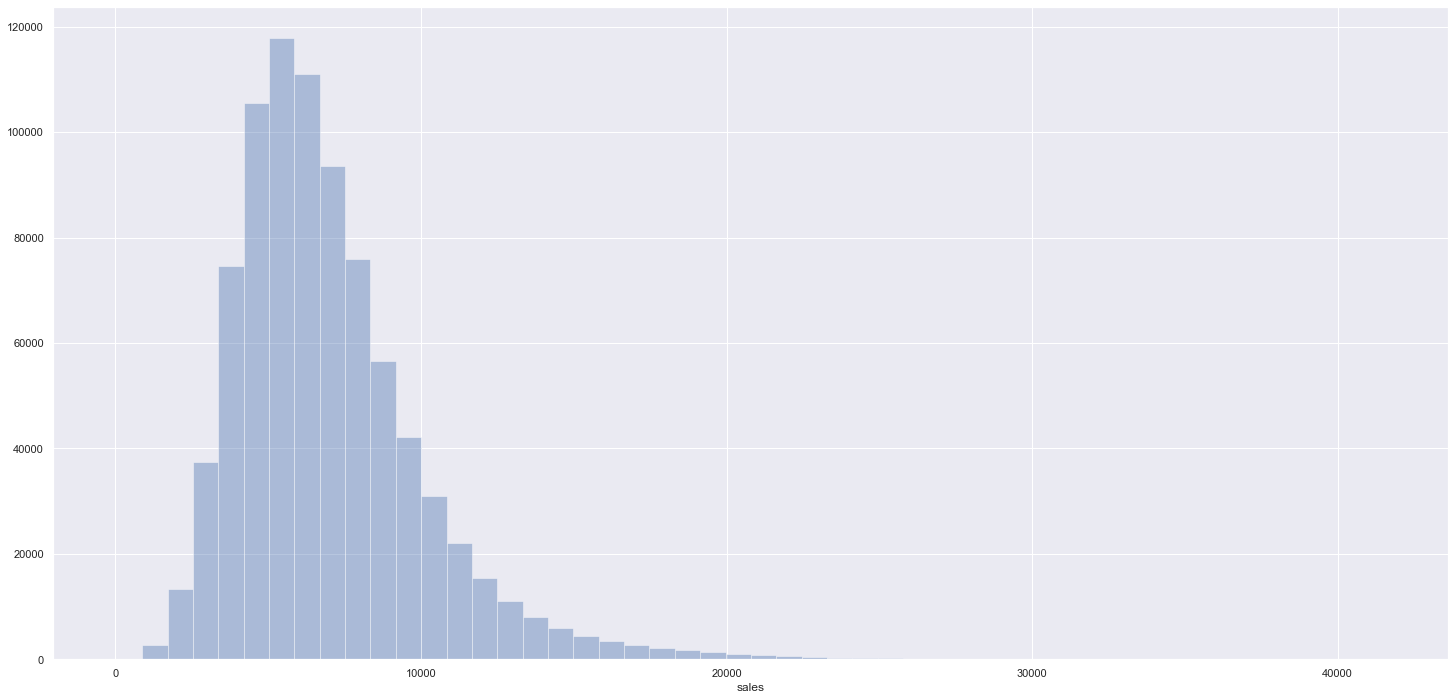

In [26]:
sns.distplot( df4['sales'], kde=False );

### 4.1.2. Numerical Variables

**Assumptions:**

- **competition_distance**: we have a greater concentration in smaller competitions, with less distance in front of the competitors, which tells us that all my competitors are very close


- **competition_open_since_month**: it's interesting, because we have the view of which months the competitors open their stores, especially April and September, which we can see a behavior in variables to help us understand the behavior, since variables like day_of_week that have no variation , does not teach us anything about the data


- **is_promo**: we have much more sales when we don't have a promotion than when we have an active promotion, which makes sense because we have many more days without promotions


- **promo2_since_week and promo2_since_year**: we cannot infer insights for this variable, what can be done is to sit down with the business team and better understand the reasons

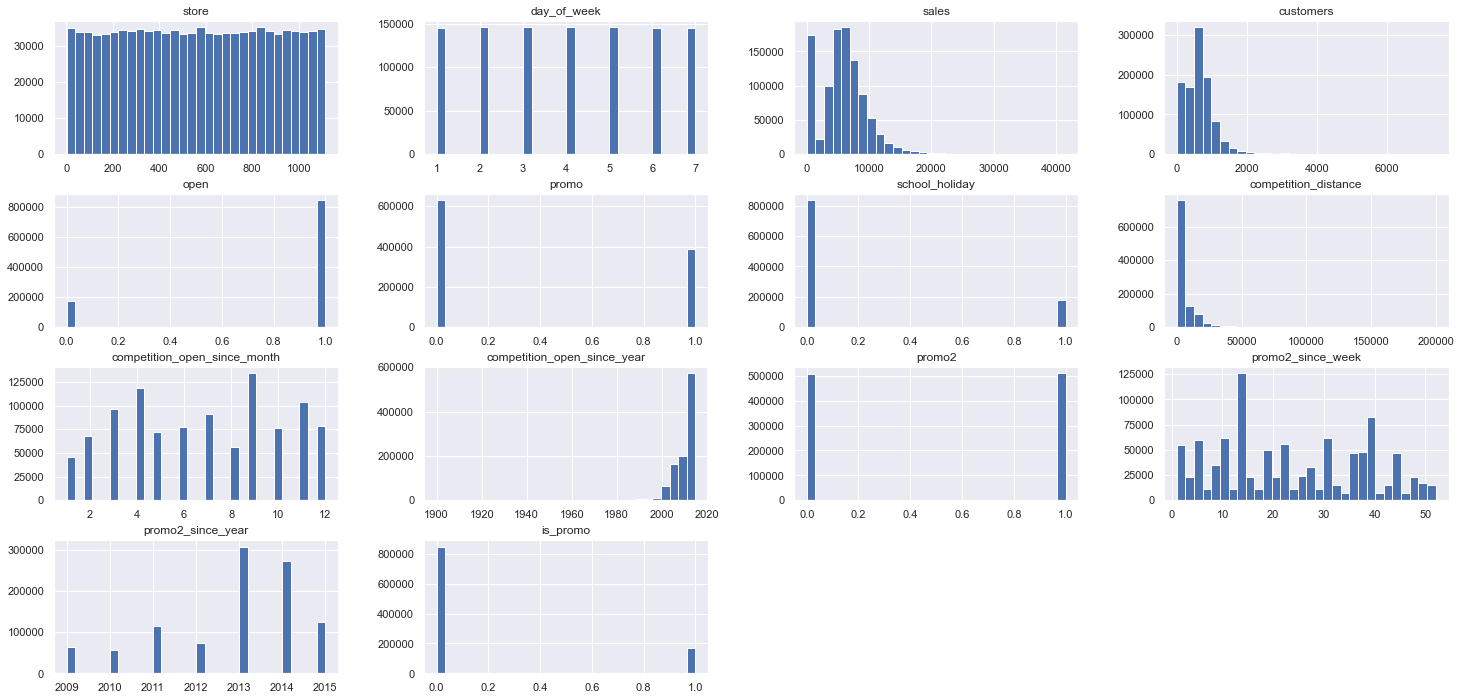

In [27]:
num_attributes.hist(bins=30);

### 4.1.3. Categorical Variables

**Assumptions:**

- **state_holiday**: As we have many more regular days than holidays, I made the plot disregarding the regular days so that we could count the difference between the holidays and check if in any of them we have a higher volume of sales. After this differentiation, we see that in public holidays we sell much more than other types of holidays, it is also something to be validated with the business team, but I believe this is because Easter and Christmas happen only once a year each while the other holidays that happens during the year are being grouped into public holidays. Looking at the distribution, we see something very close to a normal distribution for most holidays, which shows us that this variable is important to the model;


- **store_type**: We see that type A stores have a higher sales volume than the others followed by D and looking at the distribution, we see something very close to a normal distribution for most stores, which shows us that this variable is also relevant for the model;


- **assortment**: We see in this variable that stores with basic and extend assortments have a higher sales volume than extra. Looking at the distribution we see that stores with extra assortment have a lower peak, but they have a much more divided distribution than the others, which shows us that we have more stores with extra assortment.

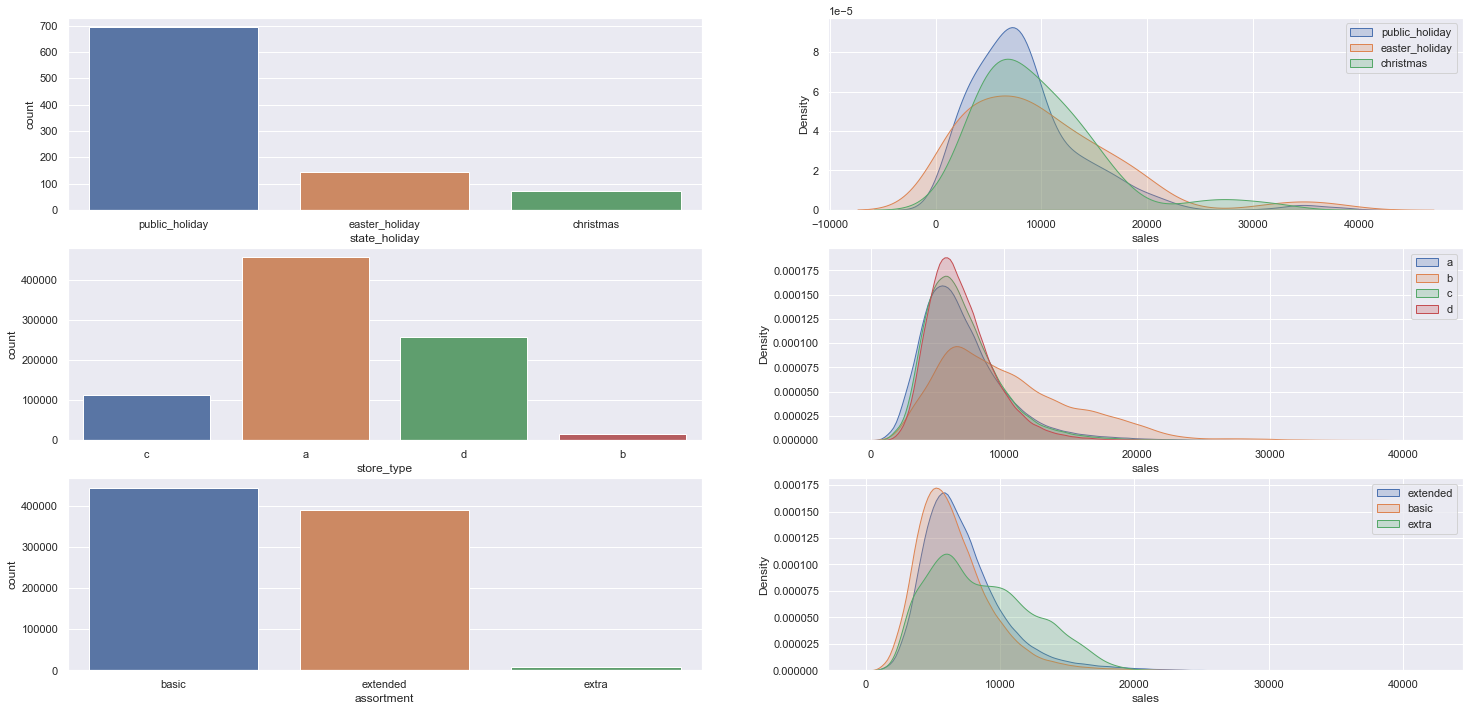

In [28]:
# state_holiday
plt.subplot( 3, 2, 1 );
a = df4[df4['state_holiday'] != 'regular_day'];
sns.countplot( a['state_holiday']);

plt.subplot( 3, 2, 2 );
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True );
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True );
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True );
plt.legend();

# store_type
plt.subplot( 3, 2, 3 );
sns.countplot( df4['store_type']);

plt.subplot( 3, 2, 4 );
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True );
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True );
plt.legend();

# assortment
plt.subplot( 3, 2, 5 );
sns.countplot( df4['assortment']);

plt.subplot( 3, 2, 6 );
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True );
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True );
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True );
plt.legend();


## 4.2. Bivariate Analysis

In this analysis, the goal is to validate the hypotheses raised, aiming to understand how each variable impact the response variable, in this case sales.

### H1. Stores with larger assortments should sell more.

**FALSE** Stores with the BIGGEST ASSORTMENT sell the LESS.

- As we do not have much information about the different types of assortments, I'm assuming that the extra type are stores with a greater assortment of products, which lead us to invalidate our hypothesis.

<AxesSubplot:xlabel='year-week'>

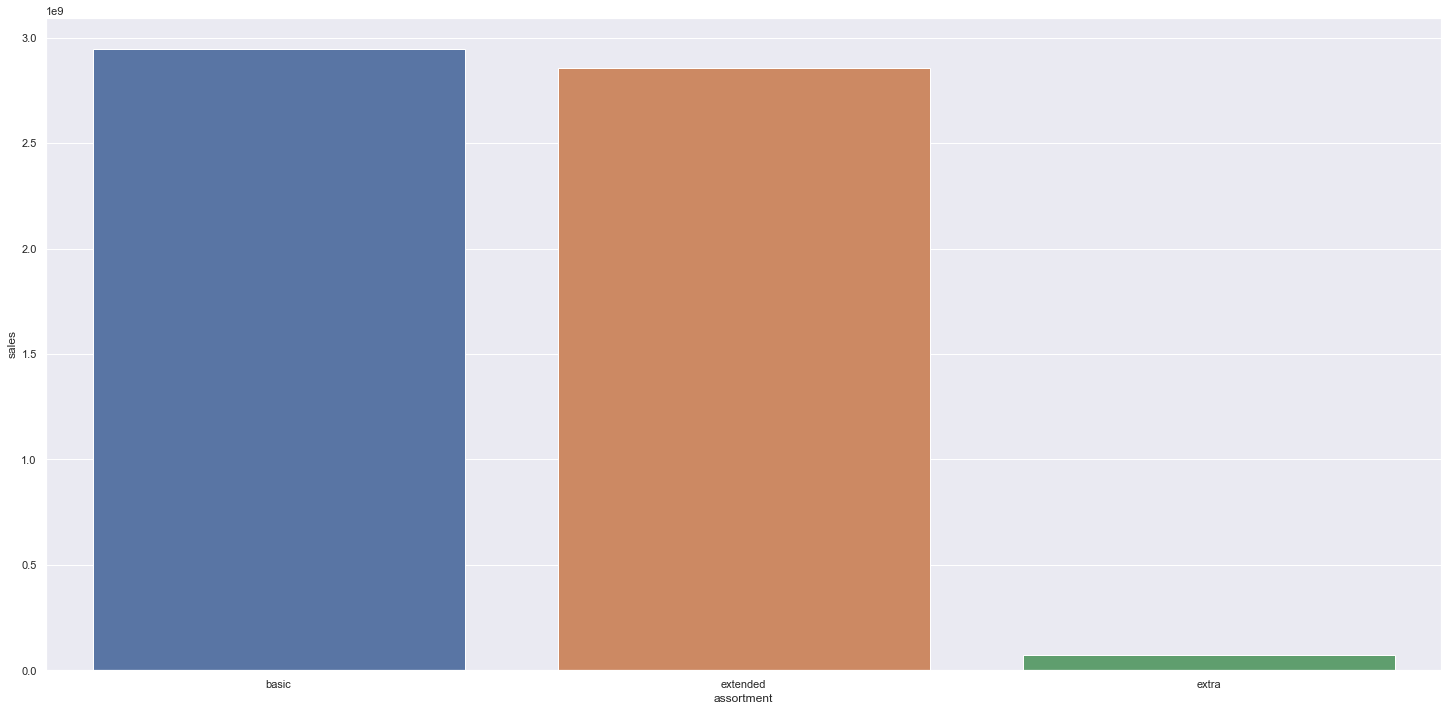

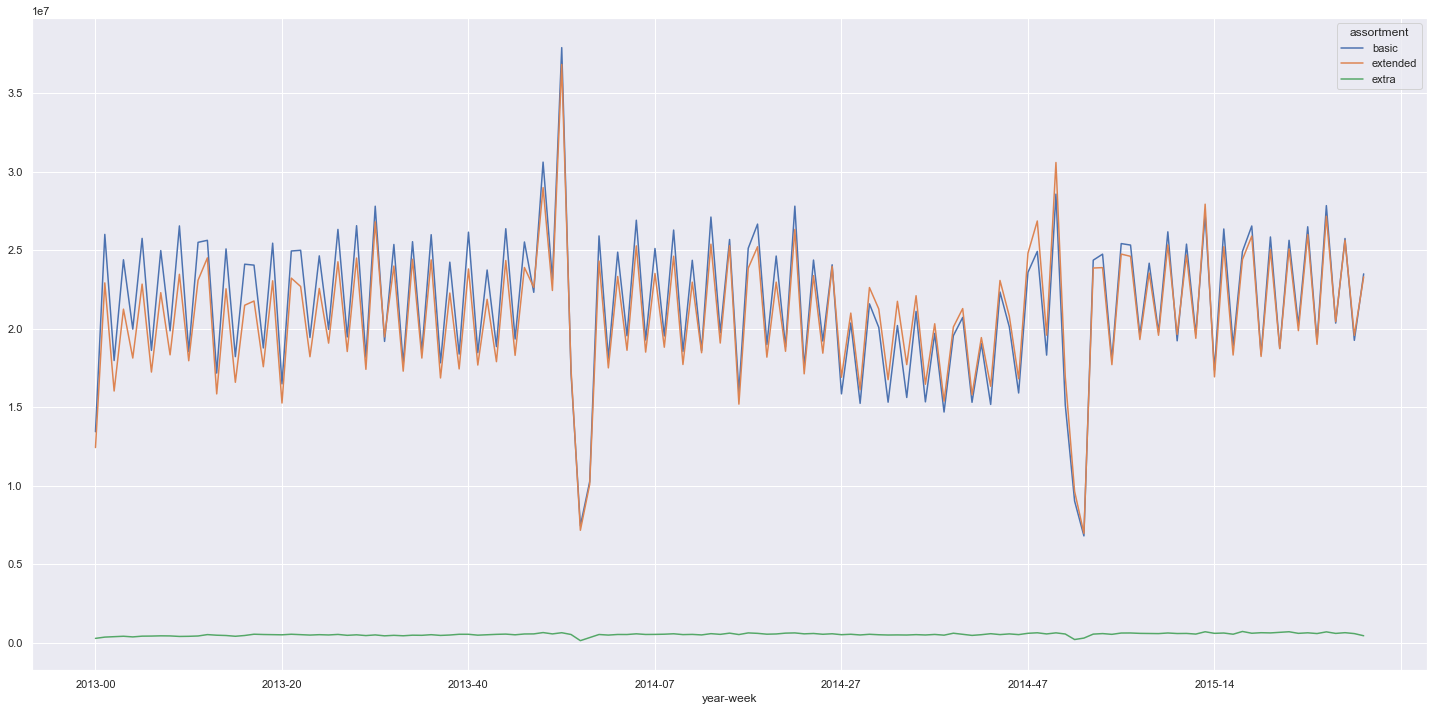

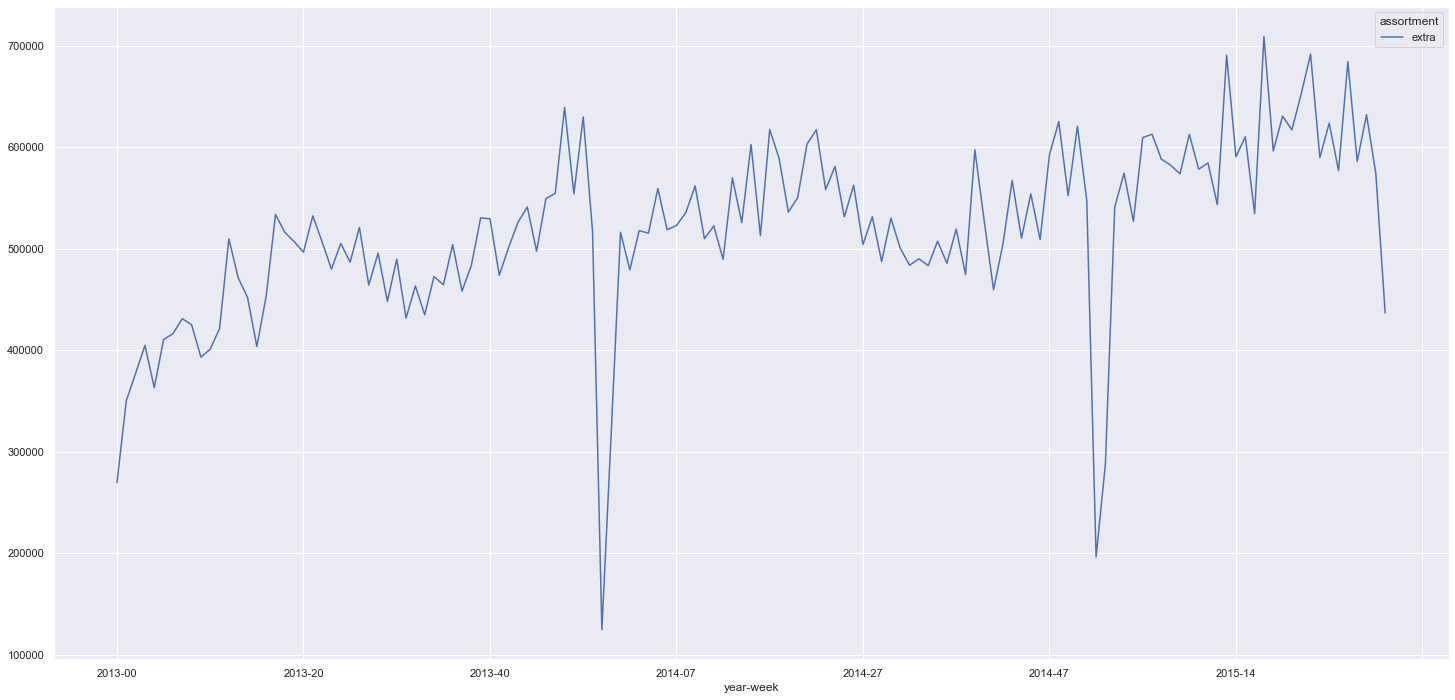

In [29]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year-week','assortment','sales']].groupby( ['year-week','assortment'] ).sum().reset_index()
aux2.pivot( index='year-week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year-week', columns='assortment', values='sales' ).plot()

### H2. Stores with closer competitors should sell less.

**FALSE** Stores with closer COMPETITORS sell MORE.


- We see that the highest sales volume is in competitors with a distance of up to 1,000 meters, which invalidates our hypothesis. 


- We also see a correlation of -0.23, which is a good correlation and tells us that the further away our competitor is, the lower the sales volume.

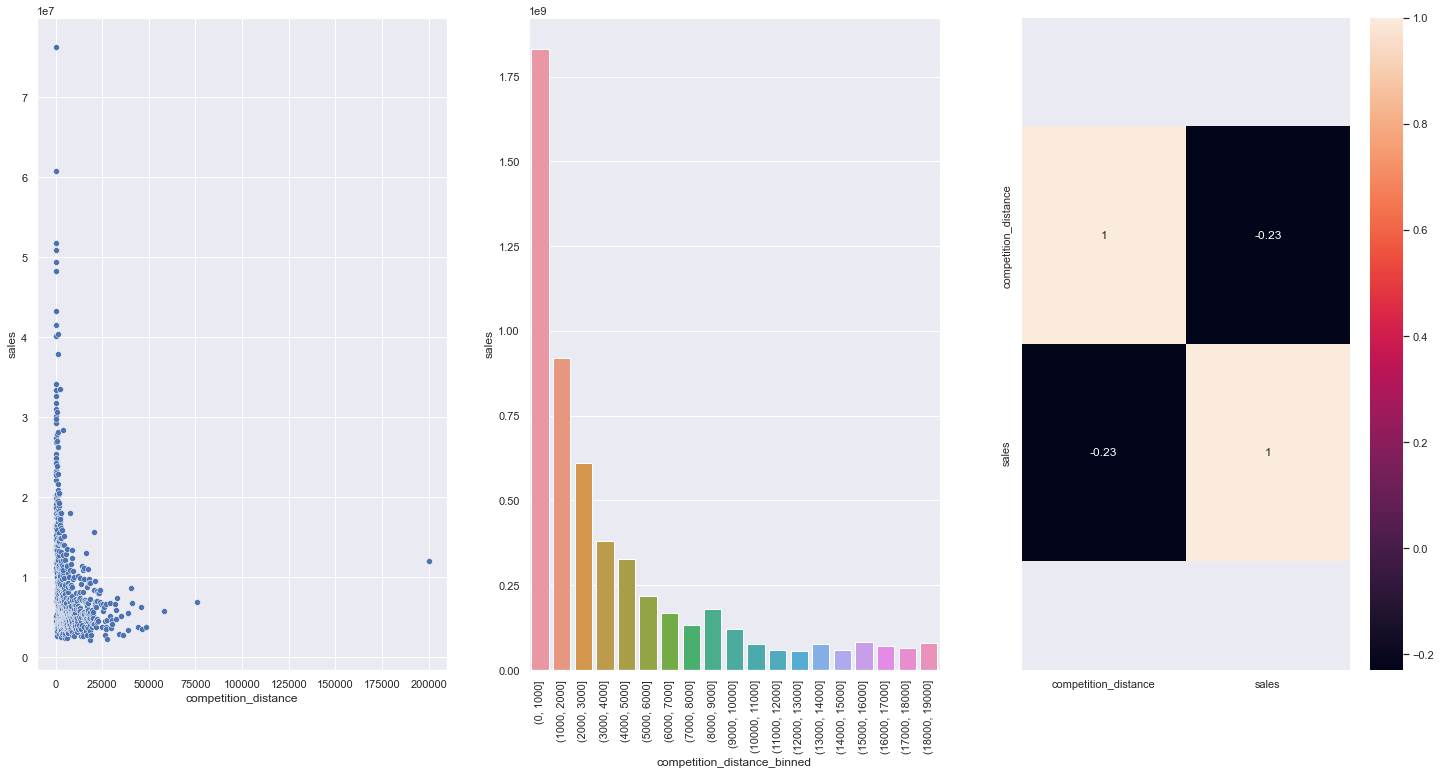

In [31]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins= list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned']= pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### H3. Stores with longer competitors should sell more.

**FALSE** Stores with LONGER COMPETITORS, sell LESS.

- The more the competition time approaches 0, the greater the sales volume, which means that the more recent the competition, the greater the sale. Which contradicts common sense, because we always think that when we have a recent competition, we have a movement in the market and different stores, which makes people want to know the new stores in the region. 


- For this variable we have a correlation of -0.1 which is an ok correlation and will be a variable for the model because it is not that close to 0.

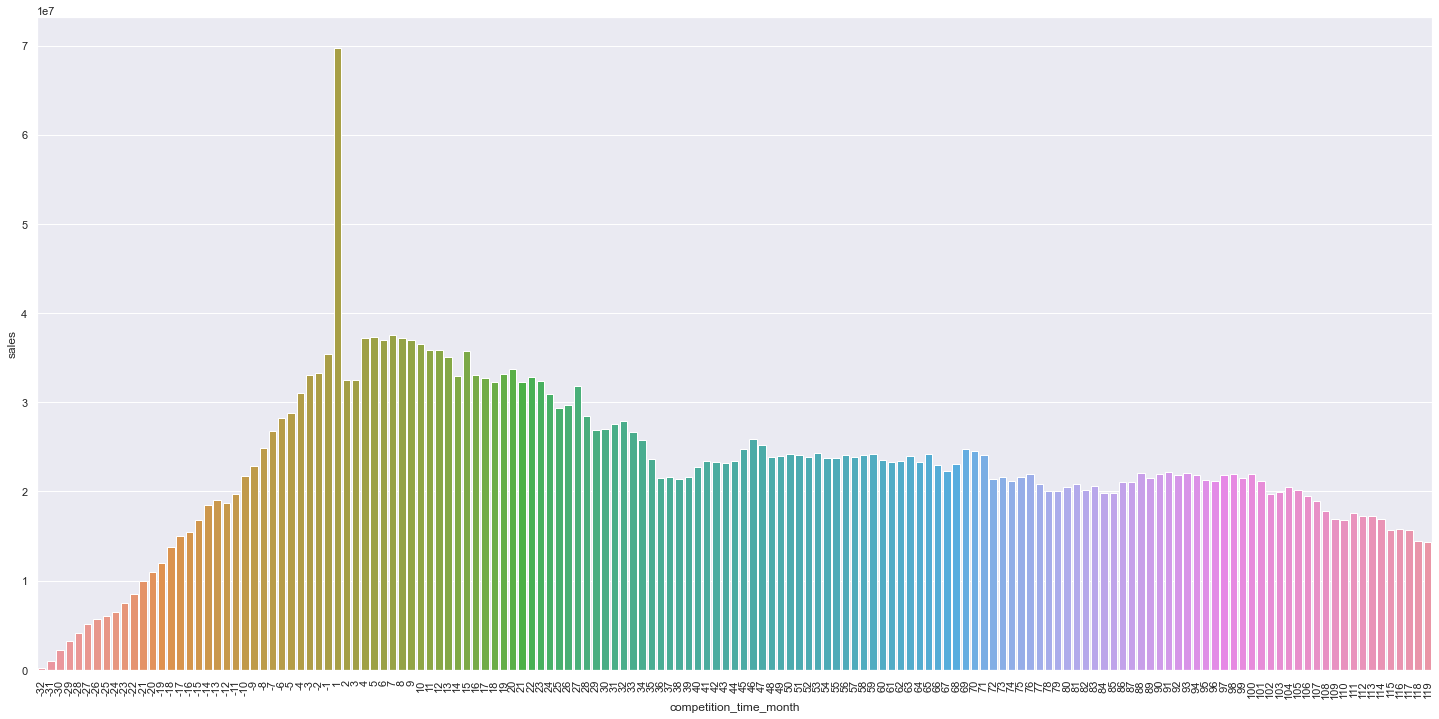

In [39]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

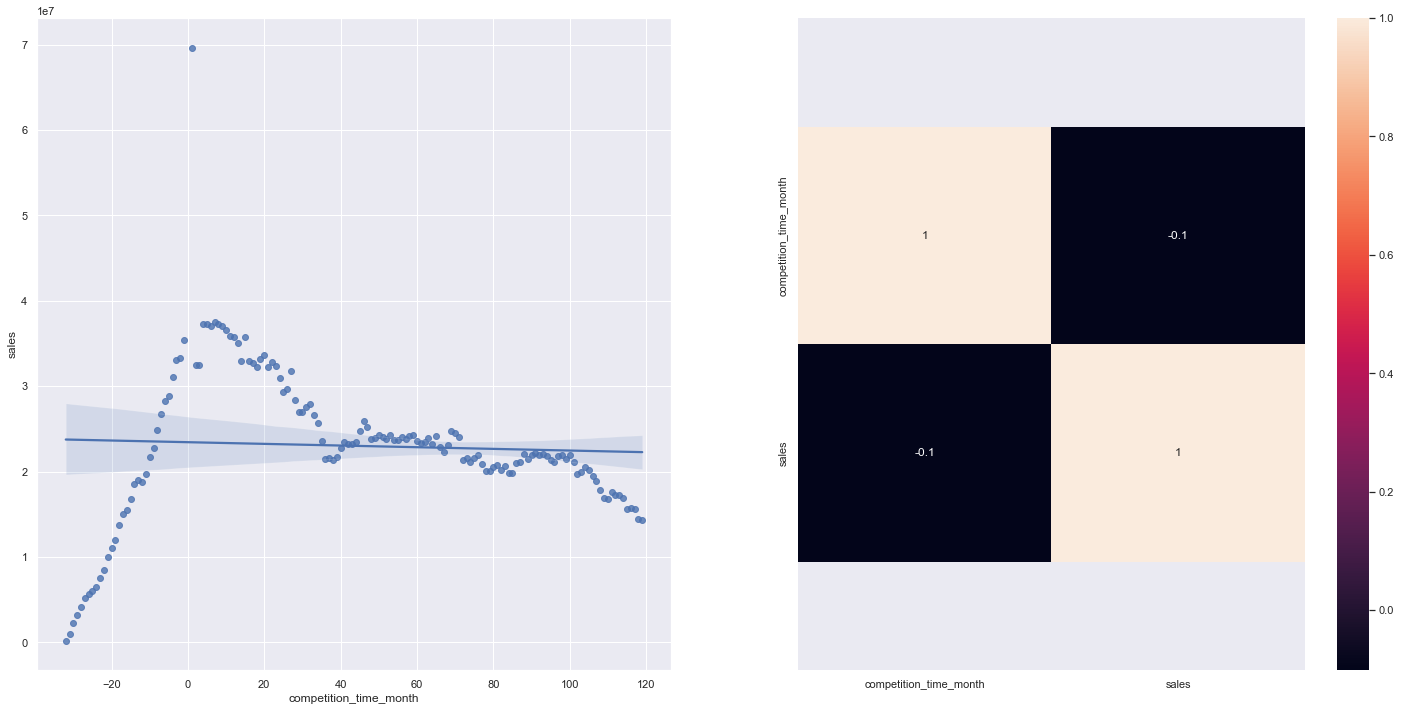

In [40]:
plt.subplot( 1, 2, 1 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 2, 2 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### H4. Stores with longer active promotions should sell more.

**FALSE** Stores with PROMOTIONS ON FOR LONGER, SELL LESS after a certain period of promotion.

- Looking at the first graph with the extended promotion periods, we see that it only works for a certain period and then sales start to fall and it is no longer effective, when looking at the second graph that shows us about the period close to the promotion, we see that sales are gradually increasing. Whether it's marketing, combo orders, people realizing they'll have a better opportunity to buy;


- Looking at the regression charts and analyzing the trend of the charts, we really see a positive trend for the regular period and a negative trend for the extended promotion period;


- Looking at the correlation between sales and the promo time week, we have only 0.029, which is very weak, most likely due to the constant period which is much longer than the decay period, so it forces the correlation to be weaker because there is no rise sharp

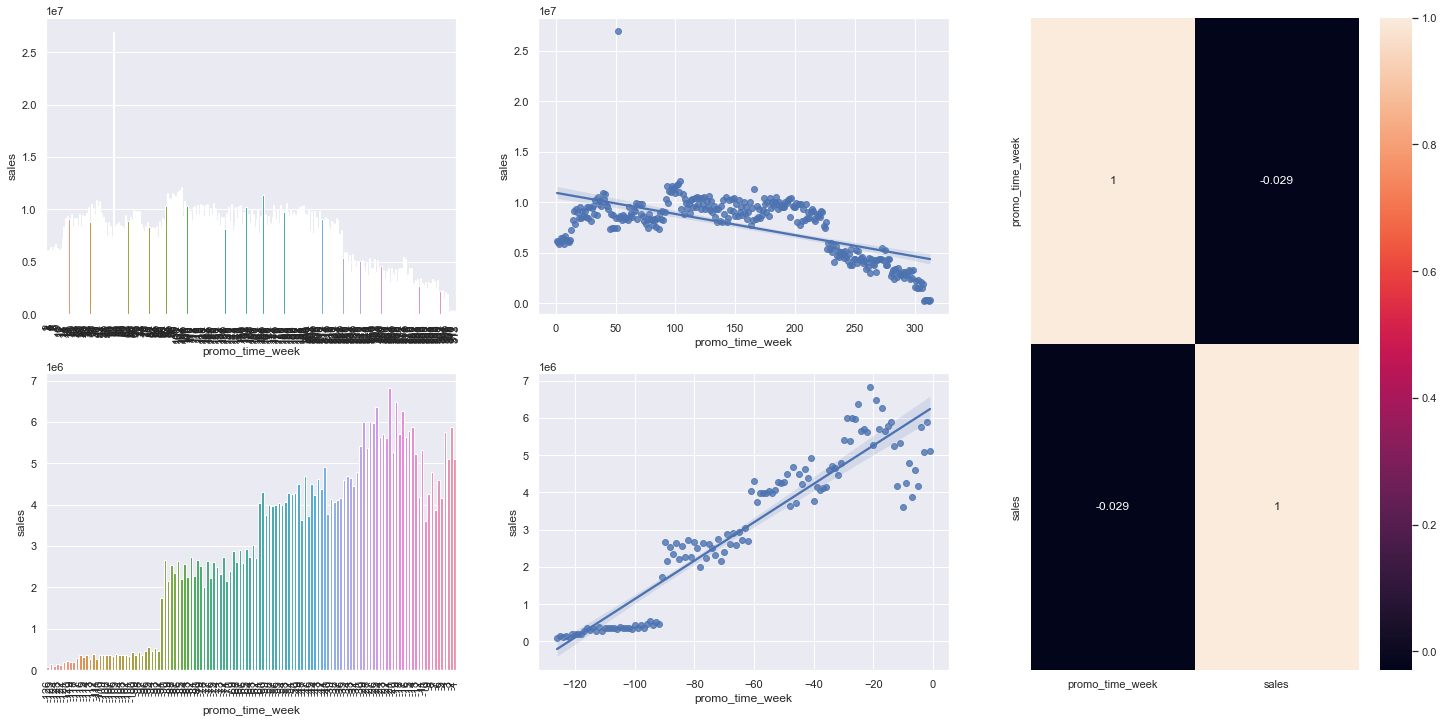

In [33]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo exetendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0, 1])
sns.regplot( x='promo_time_week', y='sales', data=aux2 );


plt.subplot( grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1, 1])
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[ :, 2])
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H5. Stores with more consecutive promotions should sell more.
**FALSE** Stores with CONSECUTIVE PROMOTIONS sell LESS.

- We see that the behavior of stores that participated in consecutive promotions is pretty similar, but the sales volume is higher for stores that do not participate in extended promotions;


- Analyzing the relevance to the model, we see that it has a very punctual behavior, only in one period the data differ, so based on that look, I don't believe this variable is relevant.

In [34]:
df4[['promo', 'promo2','sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


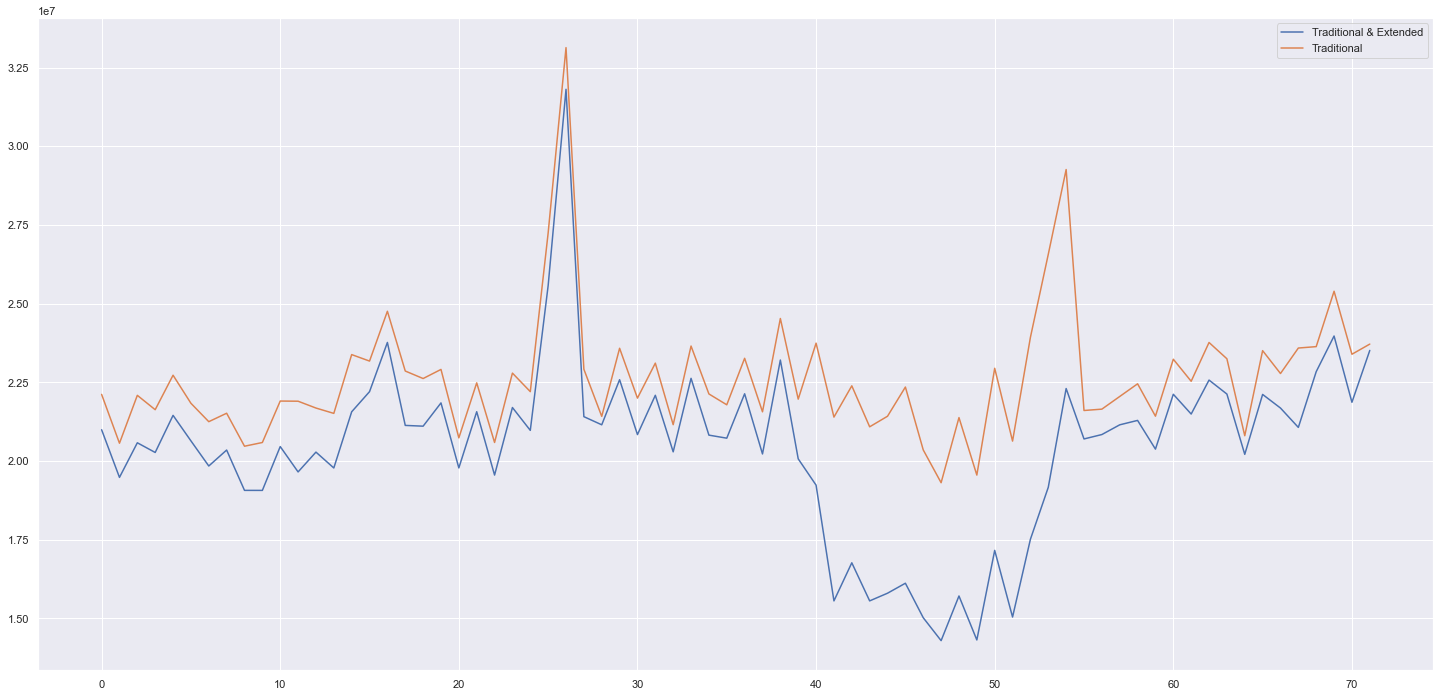

In [41]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1)][['year-week', 'sales']].groupby('year-week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0)][['year-week', 'sales']].groupby('year-week').sum().reset_index()
aux2.plot( ax=ax );

ax.legend( labels= ['Traditional & Extended', 'Traditional'] );

### **H6.** Stores open during the Christmas holiday should sell more.

**FALSE** At Christmas we do not sell more than other holidays.

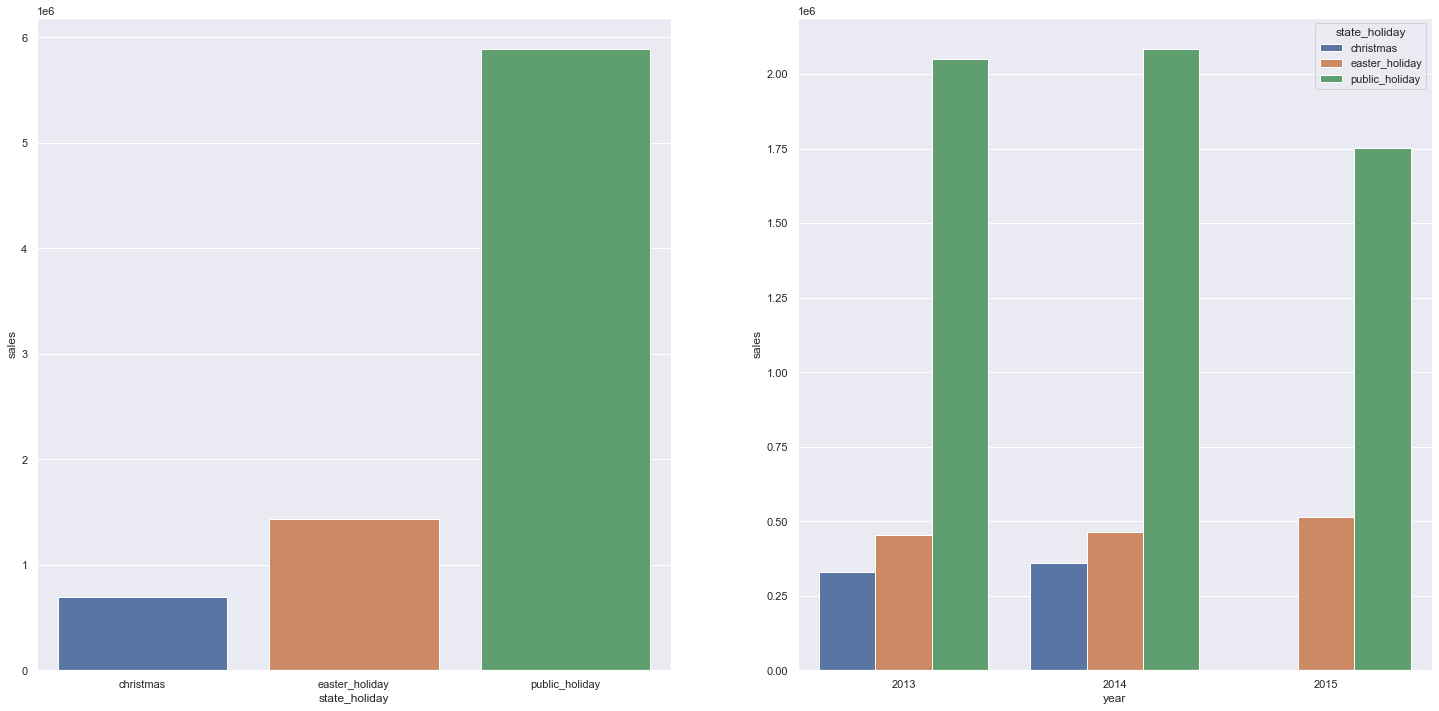

In [36]:
plt.subplot( 1, 2, 1 )
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2 )
aux2 = aux[['year','state_holiday','sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H7.** Stores should sell more over the years.

**FALSE** Stores sell less over the years.

- We have a decreasing trend seeing the reg plot graph;


- With a correlation of -0.92 we can infer that it is very strong negatively, which confirms that as the years progress, sales decreases. But we have to be careful in this inference, because the year 2015 is not complete since the data only go up to August;


- So we can infer that the year is a relevant variable for the model.

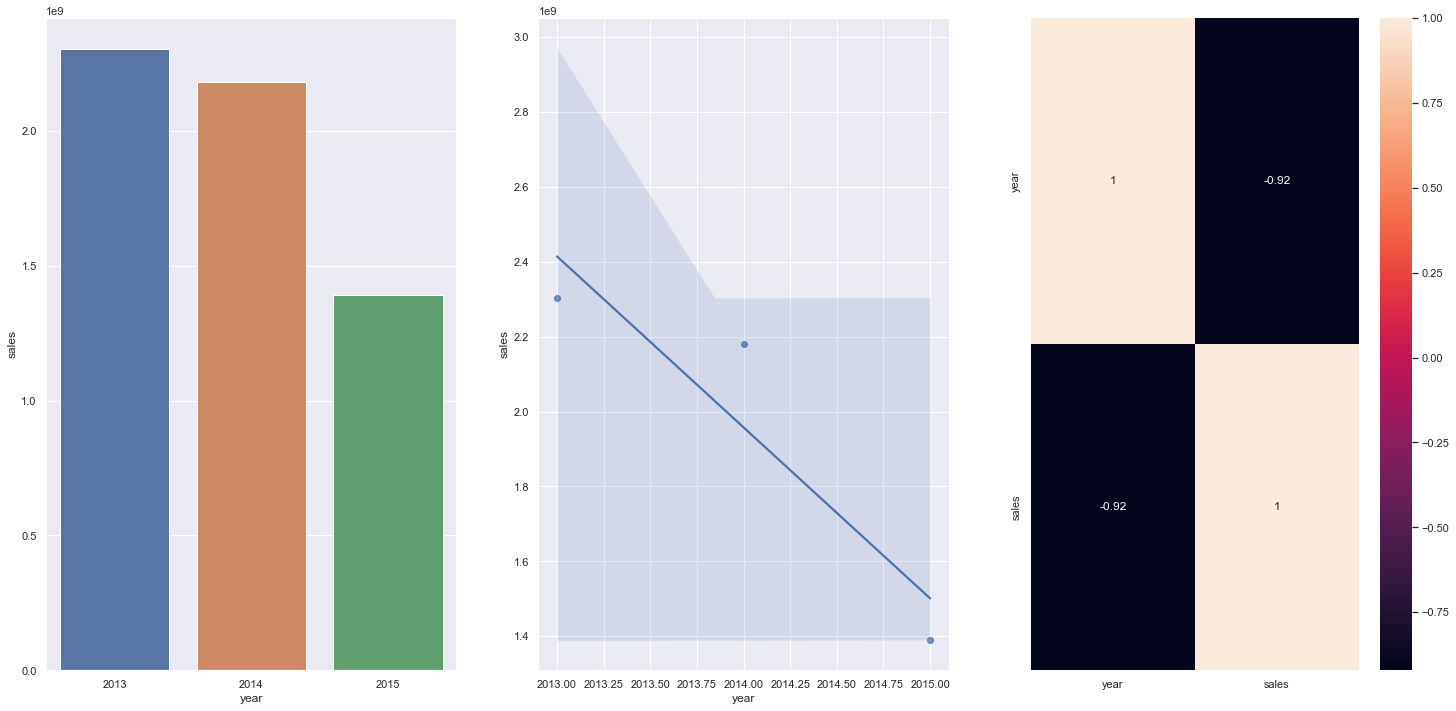

In [37]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### **H8.** Stores should sell more in the second half of the year.
**FALSE** Stores sell less in the second half of the year

But we must also be careful with this statement, remembering that the year 2015 does not have its second semester complete, so we cannot infer with 100% certainty.

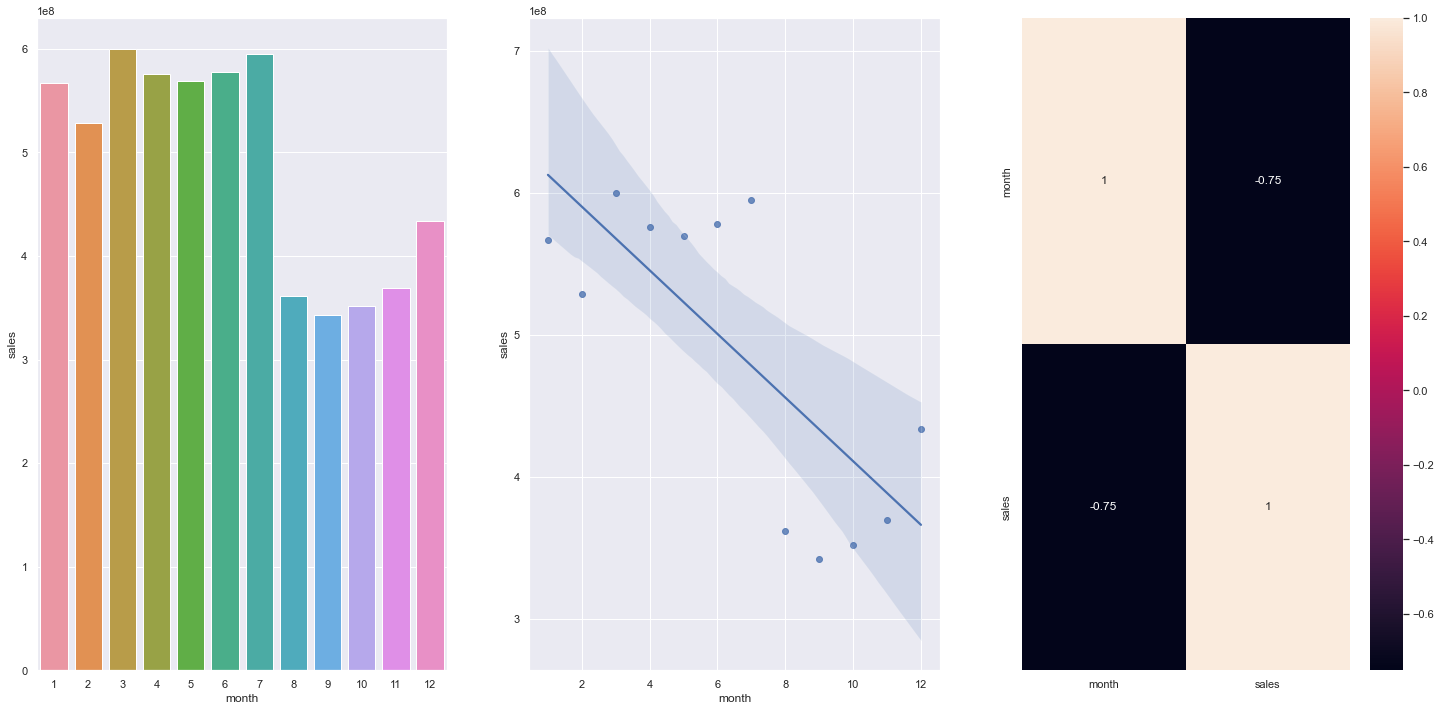

In [38]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

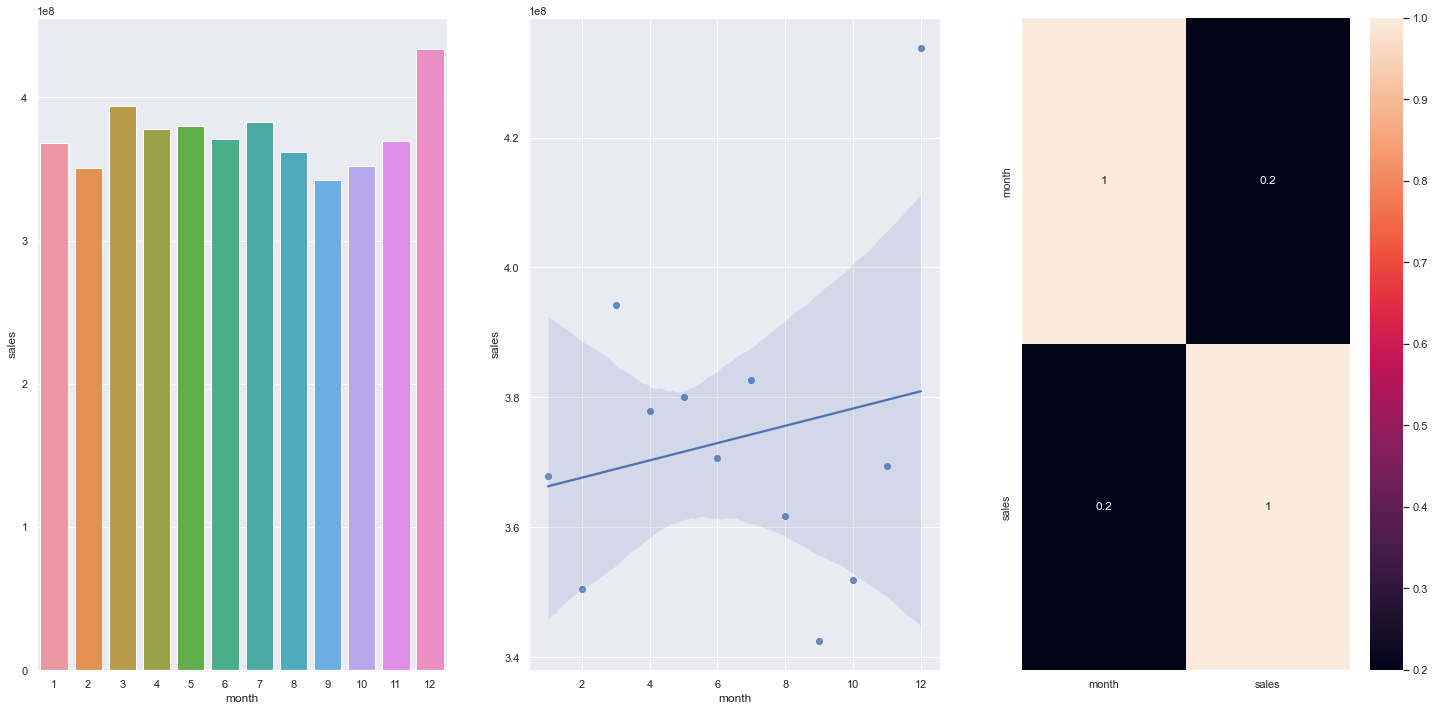

In [39]:
aux1 = df4.loc[df4['year'] != 2015]
aux1 = aux1[['month','sales']].groupby('month').sum().reset_index()


plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### **H9.** Stores should sell more after the 10th of each month.
**TRUE** Stores SELL MORE after the 10th of each month. 

- I also took the opportunity to make a comparison between sales in each fortnight of the month and in the last 10 days, which proved that when looking at fortnight, we have a very similar sales volume;


- Looking at the division before and after the 20th day, we have a similar behavior compared to the tenth day of the month, where we have much more sales before the 20th, which leads us to believe that we have this behavior because we have twice as many days.

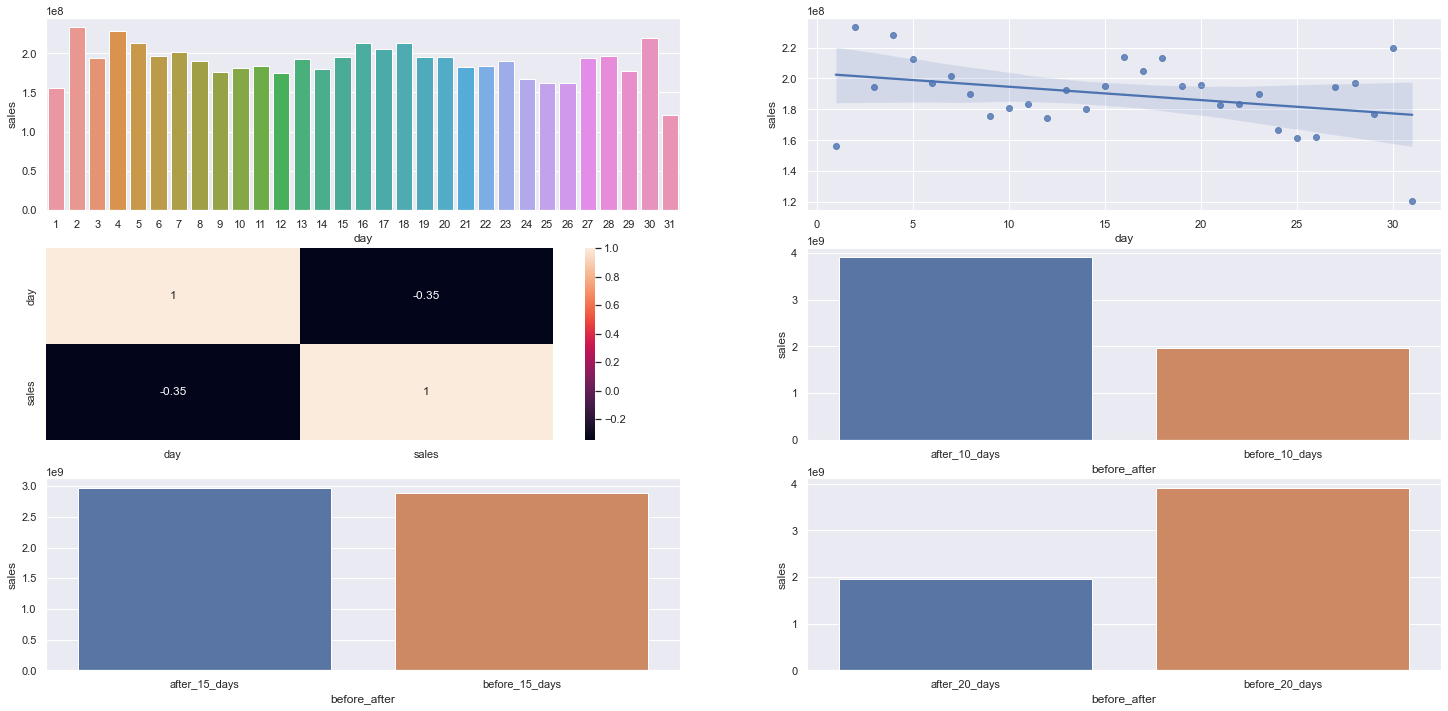

In [40]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot( 3, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 3, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 3, 2, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

plt.subplot( 3, 2, 4 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

plt.subplot( 3, 2, 5 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_15_days' if x <= 15 else 'after_15_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

plt.subplot( 3, 2, 6 )
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_20_days' if x <= 20 else 'after_20_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()
sns.barplot( x='before_after', y='sales', data=aux2 );

### **H10.** Stores should sell less on weekends.
**TRUE** Stores sell less on weekends.

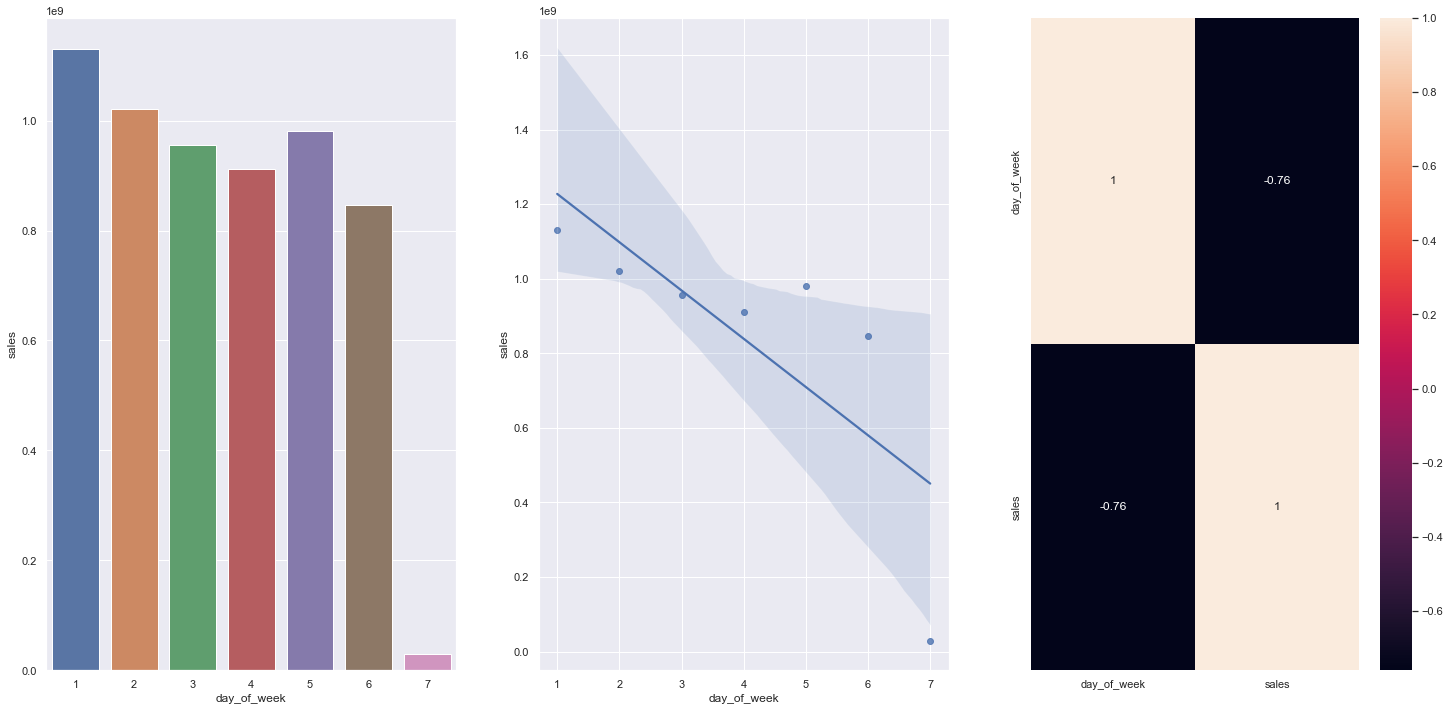

In [41]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );

### **H11.** Stores should sell less during school holidays.
**TRUE** Stores SELL LESS on school holidays. 

- Except in the months of JULY and AUGUST where sales begin to change, with sales in July with very similar volumes and in August sales on school holidays are higher.

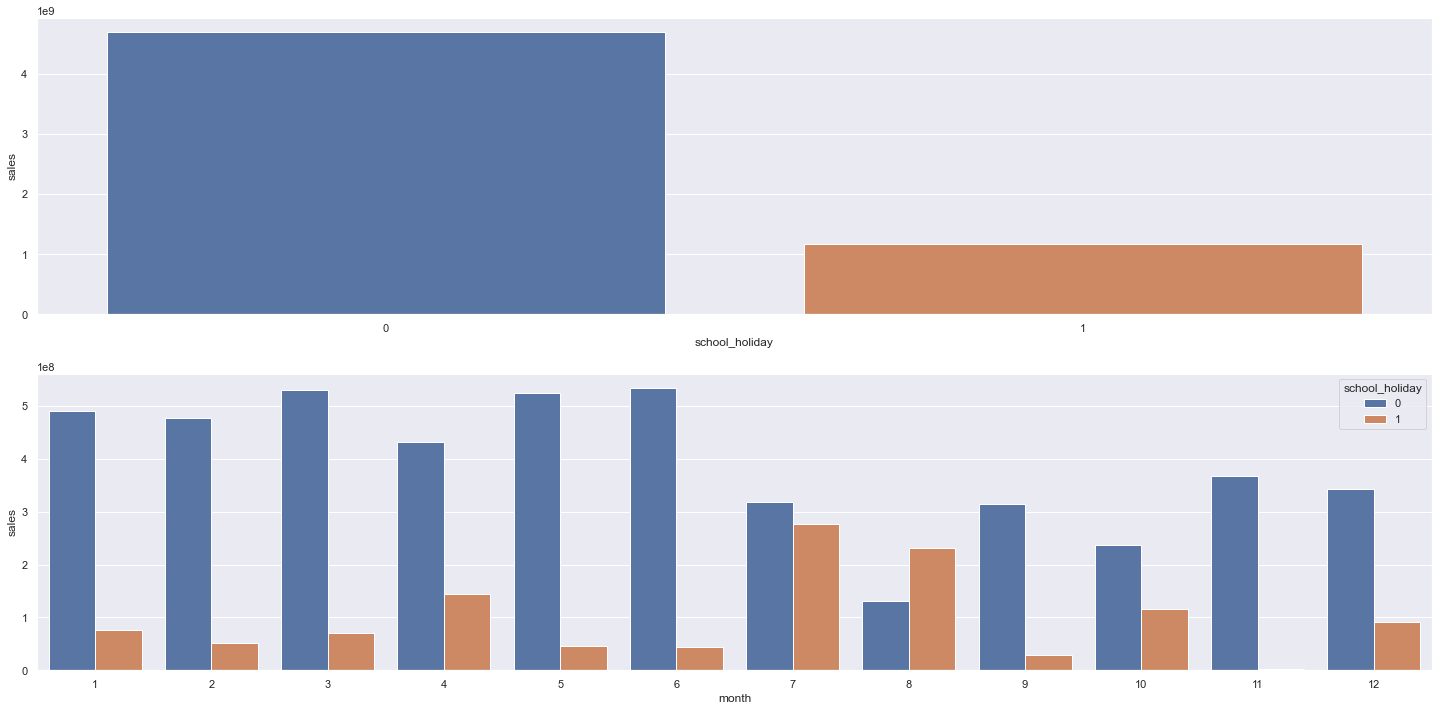

In [42]:
plt.subplot( 2, 1, 1 )
aux1 = df4[['school_holiday','sales']].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot( 2, 1, 2 )
aux2 = df4[['month','school_holiday','sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='sales', hue='school_holiday',data=aux2 );

## 4.2.1 Hypothesis Summary

In [43]:
table = [['Hipothesis','H1','H2','H3','H4','H5','H6','H7','H8','H9','H10','H11'],
        ['Conclusion','False','False','False','False','False','False','False','False','True','True','True'],
        ['Relevance','Lower','Medium','Medium','Lower','Lower','Medium','Higher','Higher','Higher','Higher','Lower']]

print( tabulate(table, headers='firstrow', tablefmt='grid'))

+--------------+-------+--------+--------+-------+-------+--------+--------+--------+--------+--------+-------+
| Hipothesis   | H1    | H2     | H3     | H4    | H5    | H6     | H7     | H8     | H9     | H10    | H11   |
+==============+=======+========+========+=======+=======+========+========+========+========+========+=======+
| Conclusion   | False | False  | False  | False | False | False  | False  | False  | True   | True   | True  |
+--------------+-------+--------+--------+-------+-------+--------+--------+--------+--------+--------+-------+
| Relevance    | Lower | Medium | Medium | Lower | Lower | Medium | Higher | Higher | Higher | Higher | Lower |
+--------------+-------+--------+--------+-------+-------+--------+--------+--------+--------+--------+-------+


## 4.3. Multivariate Analysis

In this section, the goal is to understand how the variables correlate, not only with the response variable, but also between each other. Another motivation for this section is to follow Occam's razor philosophy which says that having several models to choose from, always take the least complex possible and one way to reduce the complexity of a dataset is to eliminate irrelevant variables for the model.

### 4.3.1 Numerical Attributes

**Assumptions:**

- To read the graph below, we assume that the closer to the dark color, the greater the negative correlation, and the closer to the white color, the greater the positive correlation;


- Variables that have a strong correlation with the response variable: day_of_week, open, promo. 

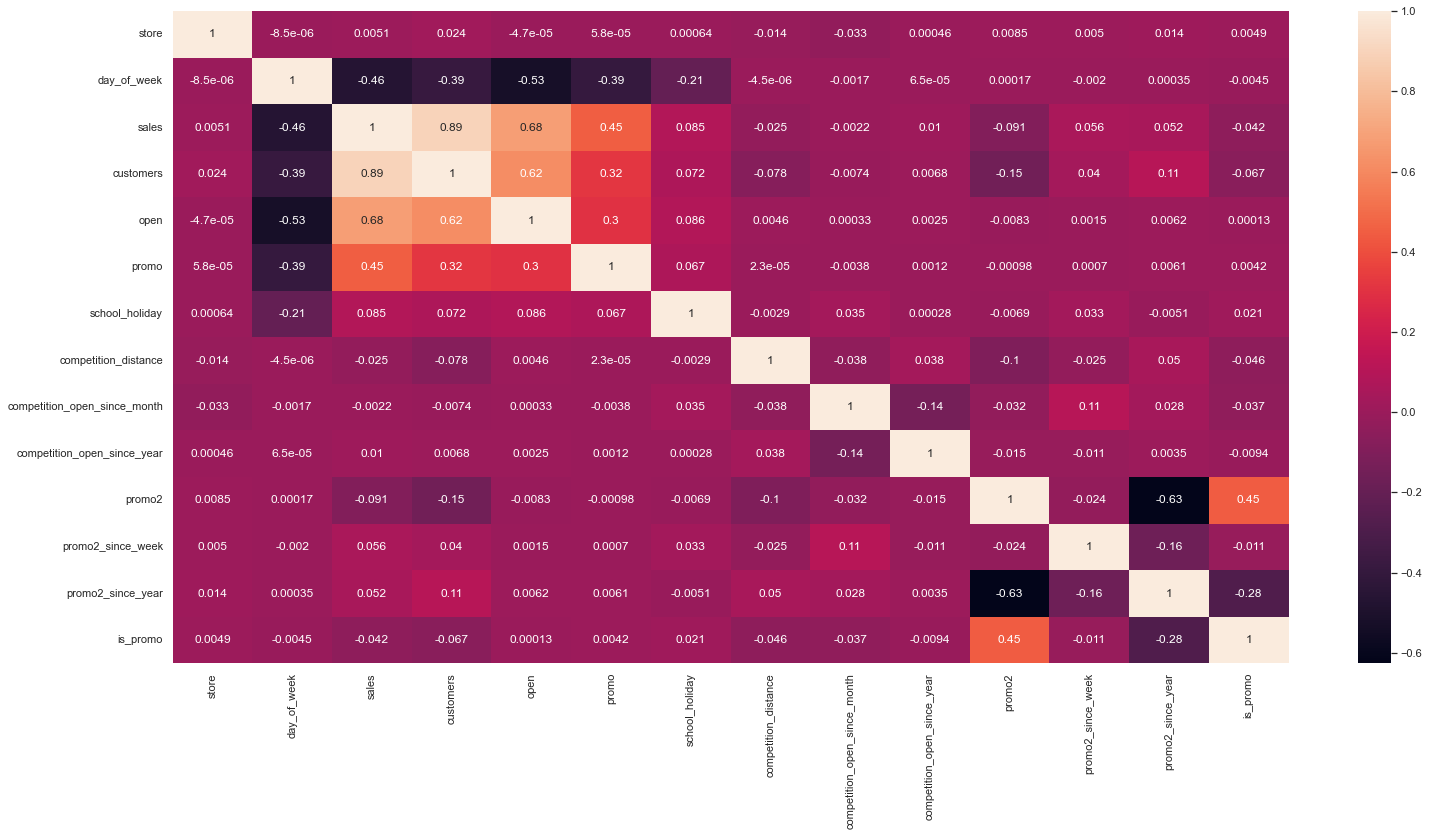

In [44]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap( correlation, annot=True);

### 4.3.2 Categorical Attributes

**Assumptions:**

- The confusion matrix below, does all the correlations between categorical variables entered and it counts the number of rows for each type. With this, we calculate the correlation based on the cramer v;


- We see that state_holiday is not related to store_type and to assortment;

- Store_type has a very strong correlation with assortment, which makes sense because the bigger the store type, the more stuff I can put

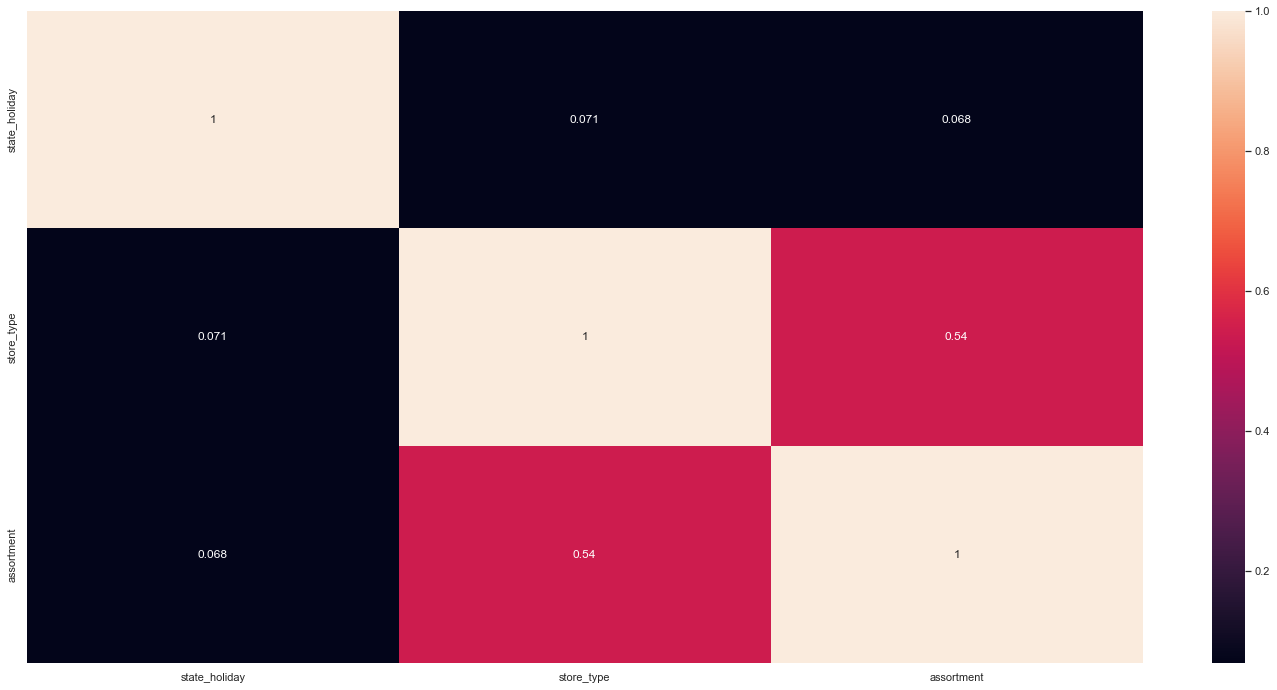

In [45]:
# filtering only categorical data
a = df4.select_dtypes( include='object')

# calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'] )
a2 = cramer_v(a['state_holiday'], a['store_type'] )
a3 = cramer_v(a['state_holiday'], a['assortment'] )

a4 = cramer_v(a['store_type'], a['state_holiday'] )
a5 = cramer_v(a['store_type'], a['store_type'] )
a6 = cramer_v(a['store_type'], a['assortment'] )

a7 = cramer_v(a['assortment'], a['state_holiday'] )
a8 = cramer_v(a['assortment'], a['store_type'] )
a9 = cramer_v(a['assortment'], a['assortment'] )

# final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6], 
               'assortment': [a7, a8, a9]
              })

d= d.set_index( d.columns )

sns.heatmap( d, annot=True);

# 5.0. PASSO 05 - DATA PREPARATION

The motivation for preparing the data is because most of ML algorithms learning is facilitated with numerical data and at the same scale. It is important for the data to be numerical, because the algorithms work with optimization methods, where they find the best parameters for the data set and these optimization methods use derivatives, multiplications and etc that are done in numerical variables, so we can not use categorical variables.

In [44]:
df5 = df4.copy()

## 5.1. Normalization

- Normalization rescales the center to 0 with a standard deviation of 1


- An example with our dataset, if we had the competition distance column with an average of 100m away with a standard deviation of 20, then either it goes to 120 or 80, but when I normalize this variable, I bring it from an average of 100 +- 20, for an average 0 +/- 1 shifting it to a new range, bringing all variables to the same range

- To calculate the normalization is we take the variable that is the entire column to see all the values and calculate the mean, Calculate the standard deviation, after having the mean and the standard deviation, take the first value of the column, subtract the mean and divide by the standard deviation and the result of the calculation is the new value and does this for all column values and for the next columns as well


- Looking at the distribution of data in the EDA, we see that we do not have any variable close to a normal one, which would compromise normalization, so we will not normalize any variable.

## 5.2. Rescaling (Feature Scaling)

- The purpose of this step is to Equalize the importance of variables so that the algorithm can learn what the real importance of each variable is, so we use rescaling for variables that do not have a normal distribution


- To calculate the new scale of the data, take the column that will apply the Min-Max scaler, find the average, then find the minimum and maximum value that is the range of the variable and store this value. For each original value of the variable, subtract the mean and divide by the range and the result of this account is the value of the new scale, apply this to all column values and create a new column on a new scale


- The min-max scaler has a problem which is that it is very sensitive to outliers and to solve this problem we use the robust scaler which uses the same formula as the Min-Max however, instead of subtracting the minimum value, subtract Q1 and divide by the difference between Q3-Q1


- Another approach is to apply the min-max to variables that do not have a very strong outlier and the robust scaler to those that have a very strong outlier

In [45]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( '/Users/marcoscarvalho/data-science-em-producao/parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump( rs, open( '/Users/marcoscarvalho/data-science-em-producao/parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( '/Users/marcoscarvalho/data-science-em-producao/parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( '/Users/marcoscarvalho/data-science-em-producao/parameter/year_scaler.pkl', 'wb') )

## 5.3. Tranformation (Encoding)

### 5.3.1 Encoding

- Encoding is to convert the categorical variable to numeric keeping the information content. 


- There are +/- 10 encoding types, however, we have 3 most common: One Hot Encoding, Label Encoding and Ordinal Encoding. To choose between them, we can follow the following premises:

1. Have the feeling of the data by doing the EDA, through the plots, we can understand the levels (values that the categorical variables can assume eg black, yellow, purple)


2. Testing: there's no other way to learn without testing! So take a categorical variable and try 5, 6, 7 different encoding types, train the model and then calculate the error to get an idea of which encoding works best

In [70]:
# state_holiday - One Hot Encoding
# Takes each unique column value, transforms it into a column and makes a new table marking 0 for rows that don't match it and 1 for rows that match
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding (por nao ter ordem)
# It works great when you have variables that are just names, e.g. store name, things that don't have implicit relationships.
le = LabelEncoder(  )
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( '/Users/marcoscarvalho/data-science-em-producao/parameter/store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Encoding (temos uma ordem de grandeza dentro dos niveis)
# Similar to the label, but it respects an order, for example, temperature that has cold that is less than warm, that is less than hot, that is less than very hot
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict)

KeyError: "None of [Index(['state_holiday'], dtype='object')] are in the [columns]"

### 5.3.2 Response Variable Transformation

- Bring the response variable with a distribution as close as possible to a normal one, because ML algorithms were built on certain assumptions, one of which is that the data is normally distributed, so the closer the data matches the assumptions that the algorithm was built, the better the accuracy of the model, so we transform the magnitude of the distribution of the response variable into a normal distribution, to be closer to the assumptions of the algorithm, thus increasing the accuracy


- For the response variable of our project, we will use the logarithmic transformation which basically transforms distributions that have a skew very to the right or left as close to a normal as possible, with the goal of all transforming the distribution of the response variable as close as possible to a normal one

In [47]:
df5['sales'] = np.log1p( df5['sales'] )

<AxesSubplot:xlabel='sales', ylabel='Density'>

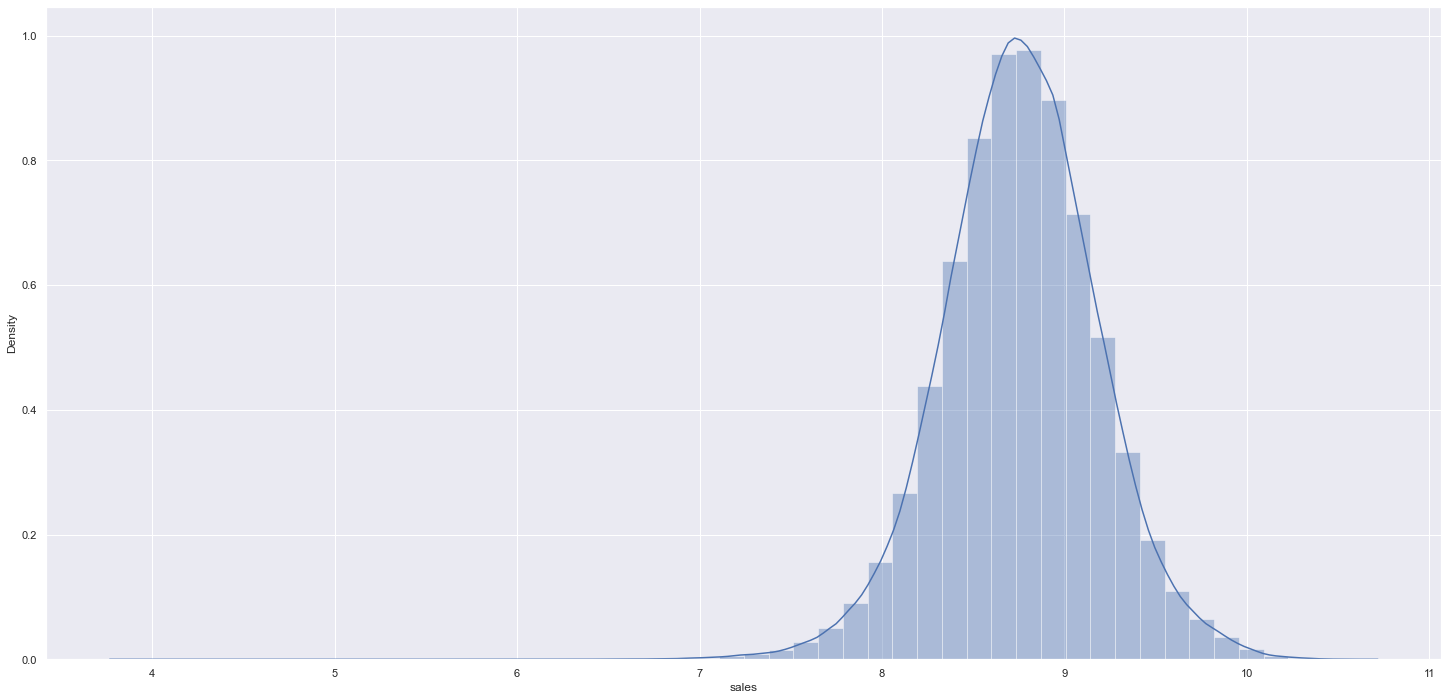

In [48]:
sns.distplot(df5['sales'])

### 5.3.3 Nature Transformation

- To encode the cycles in the data, imagine that we actually have a cycle, a wheel, with all the months, then we must observe the distances


- To transform, for example, the months into something cyclic, use the trigonometric circle


- Then you will take a variable that is the month and transform it into two variables that combined will represent the cyclical nature

In [49]:
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

In [50]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year-week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_sin,day_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0. PASSO 06 - FEATURE SELECTION

- This step goes against one of the principles of statistical learning, which is a theory that guarantees the learning of models “The simplest explanation of an observed phenomenon should prevail over more complex explanations” (Occam’s Razor)


- Given the description of a car, you build something very close to reality and with ML models is closely the same, the simplification (description) of a phenomenon that you can replicate it without even having seen, touched, anything palpable.


- If you have 2 models that represent the same phenomenon, give preference to the one that is simpler, because it probably generalizes better and describes most existing cars

In [51]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [52]:
cols_drop= ['week_of_year','day','month','day_of_week','promo_since','competition_since','year-week' ]
df6= df6.drop( cols_drop, axis=1)

In [53]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test =  X_test['sales']

print( ' Training Min Date: {}'.format( X_train['date'].min() ) )
print( ' Training Min Date: {}'.format( X_train['date'].max() ) )

print( ' \nTest Min Date: {}'.format( X_test['date'].min() ) )
print( ' Test Min Date: {}'.format( X_test['date'].max() ) )

 Training Min Date: 2013-01-01 00:00:00
 Training Min Date: 2015-06-18 00:00:00
 
Test Min Date: 2015-06-19 00:00:00
 Test Min Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

- **Random Forest**: it has the dataset, it selects the variables and divides the original set into 2 other sets and the idea of impurity is that impurity means homogeneity, so you must select the variables that divide the original dataset into 2 groups as homogeneous (similar) as possible


- **Boruta**: takes the given variables, creates a shadow variable with an alternating sequence of lines to remove the correlation between the variables, because if you make an identical copy, they will be 100% correlated. After training the model, find the importance of each of the features, both the original and the shadows

    
    - Then imagine the scenario v1 = 0.6 - v2 = 0.3 - s1 = 0.03 - s2 = 0.4 boruta looks at the shadows and determines the importance, sets it and compares each of the originals against the shadow and if the importance of the original is more important than the shadow variable, I put one in a table and if it is less important 0
    
    - Success Counts = every time it was successful (the original variable is more important than the shadow, I put 1 and otherwise 0, taking the success count and then using a binomial distribution to calculate the p-value
    
    - Once the p-value is calculated, it builds a binomial distribution and sets a trash hold, being the p-value limit
    
    - If the p-value of the variable is less than the threshold value, you confirm the variable as important, if it is greater, you reject it.

In [71]:
# training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs= -1)
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)

## 6.2.1 Best Features from Boruta

In [55]:
#cols_selected = boruta.support_.tolist()
#
# best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [56]:
cols_selected_boruta = [
                        'store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

- The motivation for using Machine Learning is to learn the behavior of a phenomenon with the available variables and then generalize it to the future


- Teach the algorithm to identify patterns in the data and use what it learned to classify, regress that object

In [57]:
df7 = df6.copy()

In [58]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

- Given the input data and the model will always predict the average, eg a rosmann store, it takes toads its sales and will extract the average and whenever it predicts future values for this store X it will always be the average


- It is very simple, but its intention here is not to solve the problem of ML or sales forecast, the main role of this model is to be a baseline of performance for the other models

In [72]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

- Keeping in mind the idea of Occan's Razor, we should always give preference to simpler models, so here we have a dataset that has a phenomenon that can be simple or complex, after the EDA it was not very clear what influence or not on sales , then simple linear algorithms are used, if these models perform well, we can assume that the dataset is linear

In [60]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.2.1 Linear Regression Model - Cross Validation

In [61]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

- It has a parameter in its formula that multiplies all the weights and depending on the value it can increase or decrease the weight, so for example if it has a very low value, it multiplies by 10 x 0.01 it is a very low value, restricting the range so that they do not burst and are comparable

In [62]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


## 7.3.1 Lasso - Cross Validation

In [63]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

- Tree-based like XGBoost, initially made for classification problems

- As I explained above how this model works, I will mention its parameters and definitions:

    1. n_estimators: how many trees will it create
    
    2. n_jobs: to run in parallel and not just one at a time
    
    3. random_state: origin of the random numbers, mainly for him to choose the variables and make the variables

In [64]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.115257,0.099842,1010.322344


## 7.4.1 Random Forest Regressor - Cross Validation

In [65]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.89 +/- 217.42,0.12 +/- 0.02,1254.75 +/- 316.61


## 7.5. XGBoost Regressor

- It uses a method called bagging and boosting, to select the fastest and most relevant features, thus having a better performance

- XGBoost parameters:
     
     1. objective: objective function
     2. n_estimators
     3. eta: how many strides does he use to do the learning
     4. max_depth: maximum branch the tree can reach
     5. subsample: how many to sample or percentage of all variables we have and want to sample to select the most relevant ones
     6. colsample_bytee: sample each of the trees

In [66]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.03, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.7 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,2599.222463,0.325109,3393.08745


## 7.5.1 XGBoost Regressor - Cross Validation

In [67]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,2890.76 +/- 339.98,0.35 +/- 0.01,3709.19 +/- 453.05


**Looking at the trained models, we see that the mean has a much smaller error than linear regression, which tells us that it is more reliable at first and that the data are complex and non-linear, so linear models will not be able to learn the behavior of data with good accuracy.**

## 7.6. Comparing Model's Performance

**To compare the performance of each model, I will use 3 metrics MAE, MAPE and RMSE. Below I let an explanation on how to analyze and understand each one.**

- **MAE (mean absolute error)**: as the name implies, it is the mean of the absolute error. MAE assigns equal weights to all errors, which means that every prediction made I will be wrong in X values. To estimate if the error is good or bad, depends on what data you have in your hand. For example when making a prediction of how many km a car travels until it breaks down in meters, the error must be small. MAE is robust with outliers and easy to understand for the business team. To do the error calculation we do the real value minus the predict value then we sum all error values and divide it by the number of predictions.


- **MAPE (mean absolute percentage error)**: MAPE is a complement to MAE. It is very simple but useful for the business team. MAPE relies to how much in percentage the prediction is from the real value average. To calculate MAPE we take the subtraction of the real and estimated value and divide it by the value of Y, thus finding the percentage far from the variable, how wrong is in front of the response variable. 


- **RMSE (root mean square error)**: RMSE squares the difference between the real value minus the predict value calculated in MAE. By calculating the RMSE you can see how much impact the outliers are leaving the model, unlike the MAE which leaves a similar weight for all. But when squaring you lose the unit of measurement and when speaking of money you change a lot, to solve this you extract the root back to the original value. Among the characteristics of the RMSE we have the assignment of greater weight to larger error and sensitivity in the presence of outliers.

### 7.6.1 Single Performance

In [68]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.115257,0.099842,1010.322344
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,2599.222463,0.325109,3393.087450


### 7.6.2 Real Performance - Cross Validation

In [69]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.89 +/- 217.42,0.12 +/- 0.02,1254.75 +/- 316.61
0,XGBoost Regressor,2890.76 +/- 339.98,0.35 +/- 0.01,3709.19 +/- 453.05


# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

- What are hyperparameters? 
    
    - Hyper parameters in machine learning, are all the contexts that the model uses to be able to learn a behavior, e.g. Random Forest (number of estimators, maximum branching of trees, number of nodes, etc.)
    
    
- What is fine Tuning? 

    - Finding the set of values and parameters that maximizes model learning

    - Cada parâmetro pode assumir uma infinidade de valores

## 8.1. Random Search

- To define parameter values in Random Search, it is good to put spaced values so as not to create a very giant list, with many interactions, hence the reason to create a spaced set

In [72]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [73]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

## 8.2. Final Model

In [88]:
param_tuned = {
    'n_estimators': 1500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.3,
    'min_child_weight': 3 
        }

In [89]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,703.328437,0.103164,1016.121898


In [92]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1(yhat_xgb_tuned) )
mpe

-0.002346069901509388

# 9.0. PASSO 09 - ERROR TRANSLATION AND INTERPRETATION

The reasons for this step are:

- How to understand the performance of the model and tell the CFO how much R$ this model will bring to the company?


- Today what the company wants to know is how much money the project will bring, how much it improves the user experience


- Machine Learning is nothing more than a tool used to bring value

In [93]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [94]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[[ 'store', 'sales', 'predictions' ]].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions' ] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[[ 'store', 'sales', 'predictions' ]].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions' ] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge( df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[[ 'store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [96]:
# best performance based on MAPE
df92.sort_values( 'MAPE', ascending=True ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
258,259,534023.31250,533460.944495,534585.680505,562.368005,0.043351
732,733,649454.25000,648753.201217,650155.298783,701.048783,0.049517
671,672,307351.28125,306909.807934,307792.754566,441.473316,0.052923
1088,1089,371856.25000,371280.018476,372432.481524,576.231524,0.053999
762,763,226936.06250,226592.578270,227279.546730,343.484230,0.054556


In [95]:
# worst performance based on MAPE
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107567.937500,104245.301616,110890.573384,3322.635884,0.575124
908,909,232030.078125,224319.941958,239740.214292,7710.136167,0.517723
875,876,198517.531250,194561.856679,202473.205821,3955.674571,0.307651
955,956,136210.093750,135548.439585,136871.747915,661.654165,0.259425
674,675,156688.796875,155881.235846,157496.357904,807.561029,0.253360


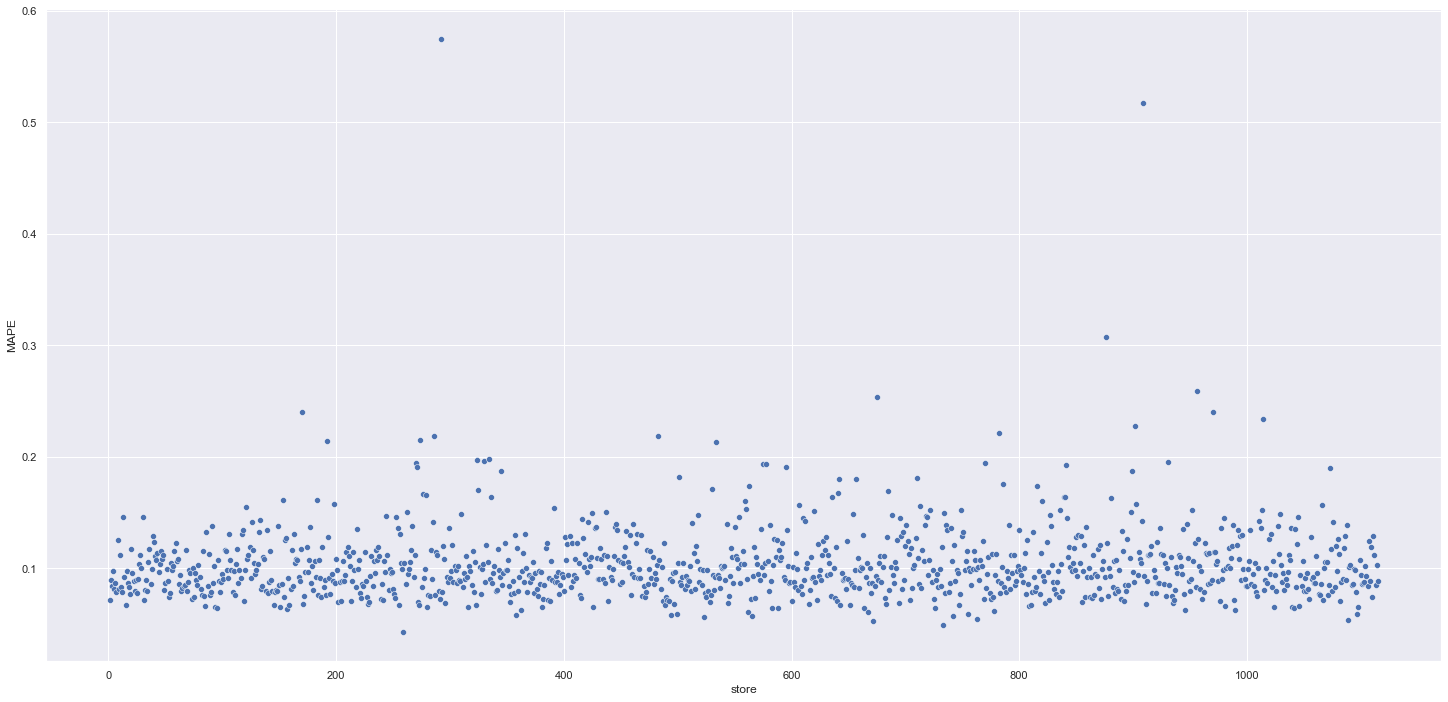

In [98]:
sns.scatterplot( x='store', y='MAPE', data=df92);

## 9.2. Total Performance

In [99]:
df93 = df92[[ 'predictions', 'worst_scenario', 'best_scenario' ]].apply(lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$283,456,064.00"
1,worst_scenario,"R$282,668,127.02"
2,best_scenario,"R$284,244,032.67"


## 9.3. Machine Learning Performance

- First graph shows that in the 6 weeks of testing, the orange line that are the predictions is very close to the real one. As I plotted all sales for all stores, it creates this shadow on the side that shows the variance


- Second graph is that the error rate which is the prediction divided by sales, so it's the percentage of my predictions against the real. If it is equal to 1 we have the perfect prediction, if it is above 1 I have an overestimation, if it is below 1 I have an underestimation. Looking at the line, we have something very close.


- Third graph shows the error distribution, which is close to a normal Gaussian.


- Fourth graph shows that according to residual analysis our predictions are good, but whenever we predict close to 30,000 we have a greater error

In [100]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

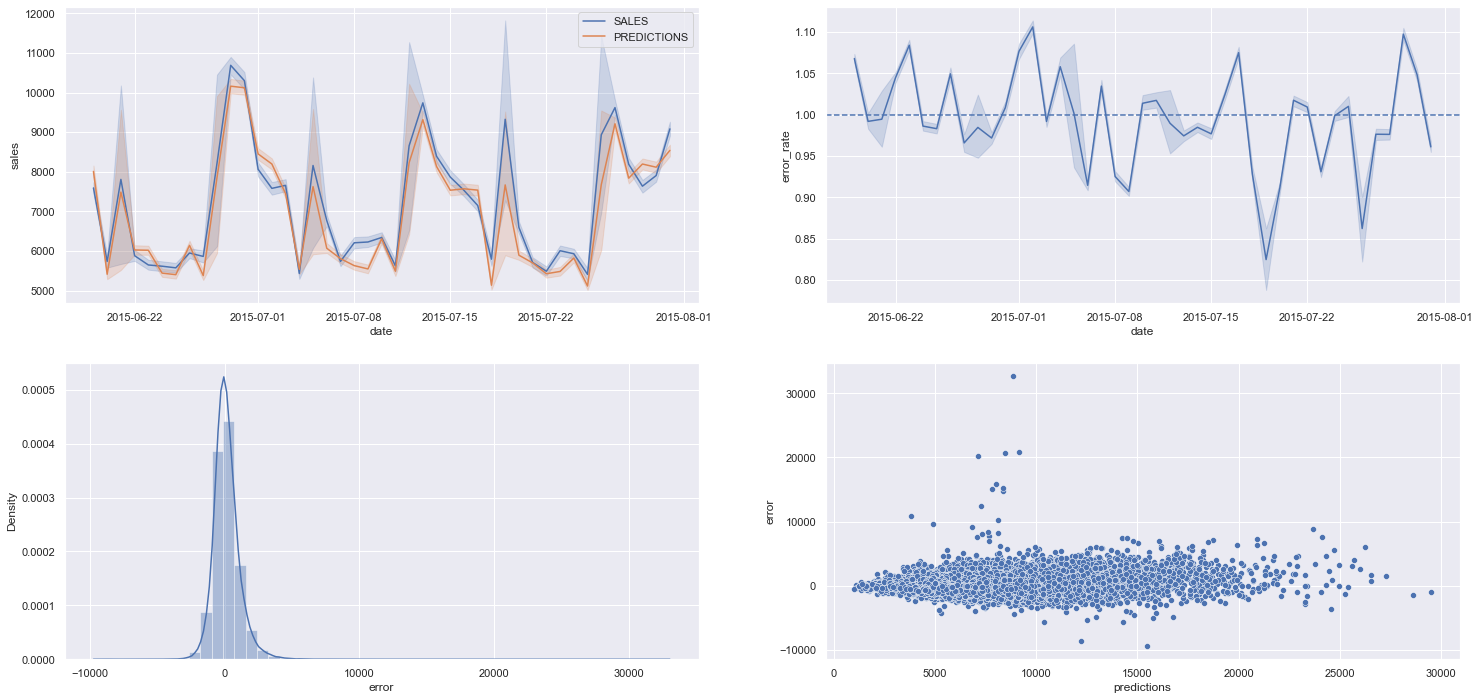

In [101]:
plt.subplot( 2, 2, 1)
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df9)
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3)
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4)
sns.scatterplot( df9['predictions'], df9['error'] )


# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [106]:
import pickle

In [109]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '/Users/marcoscarvalho/data-science-em-producao/model/model_rossmann.pkl', 'wb' ) )

## 10.1. Rossmann Class

In [110]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/Users/marcoscarvalho/data-science-em-producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [111]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/Users/marcoscarvalho/data-science-em-producao/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [77]:
import requests

In [78]:
# loading test dataset
df10 = pd.read_csv( '/Users/marcoscarvalho/data-science-em-producao/data/test.csv' )

In [79]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [24, 25, 73, 32, 33] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [80]:
# convert Dataframe to json

data = json.dumps( df_test.to_dict( orient='records' ) )

In [81]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-predict-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [82]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [83]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

Store Number 24 will sell R$318,548.16 in the next 6 weeks
Store Number 25 will sell R$354,554.88 in the next 6 weeks
Store Number 32 will sell R$176,025.30 in the next 6 weeks
Store Number 33 will sell R$263,111.69 in the next 6 weeks
Store Number 73 will sell R$183,690.54 in the next 6 weeks
